# Error analysis
Let's see where the text-only model and the reader-aware models differed, and where some outperformed others.

In [1]:
import gzip
text_only_output = list(map(lambda x: x.strip(), gzip.open('../../data/reddit_data/text_only_model/test_data_sample_top_p=0.9_temperature=1.0_output_text.gz', 'rt')))
reader_token_output = list(map(lambda x: x.strip(), gzip.open('../../data/reddit_data/author_text_data/test_data_sample_top_p=0.9_temperature=1.0_output_text.gz', 'rt')))
reader_attn_output = list(map(lambda x: x.strip(), gzip.open('../../data/reddit_data/author_text_data/author_attention_data/test_data_sample_top_p=0.9_temperature=1.0_output_text.gz', 'rt')))
reader_text_embed_output = list(map(lambda x: x.strip(), gzip.open('../../data/reddit_data/author_text_data/author_text_embed_data/test_data_sample_top_p=0.9_temperature=1.0_output_text.gz', 'rt')))
reader_subreddit_embed_output = list(map(lambda x: x.strip(), gzip.open('../../data/reddit_data/author_text_data/author_subreddit_embed_data/test_data_sample_top_p=0.9_temperature=1.0_output_text.gz', 'rt')))
print(len(text_only_output))
print(len(reader_token_output))
print(len(reader_attn_output))
print(len(reader_text_embed_output))
print(len(reader_subreddit_embed_output))

56097
56097
56097
56097
56097


In [2]:
import torch
test_data = torch.load('../../data/reddit_data/combined_data_test_data.pt')
print(len(test_data))

56097


In [3]:
## combine everything lol
import pandas as pd
combined_data = pd.DataFrame([
    text_only_output,
    reader_token_output,
    reader_attn_output,
    reader_text_embed_output,
    reader_subreddit_embed_output,
    test_data['source_text'],
    test_data['target_text'],
    test_data['reader_token_str'],
    test_data['author_has_subreddit_embed'],
    test_data['author_has_text_embed'],
    test_data['article_id'],
], index=['text_only_output', 'reader_token_output', 'reader_attn_output', 'reader_text_embed_output', 'reader_subreddit_embed_output', 'source_text', 'target_text', 'reader_token', 'author_has_subreddit_embed', 'author_has_text_embed', 'article_id']).transpose()
print(combined_data.shape)
display(combined_data.head())

(56097, 11)


,text_only_output,reader_token_output,reader_attn_output,reader_text_embed_output,reader_subreddit_embed_output,source_text,target_text,reader_token,author_has_subreddit_embed,author_has_text_embed,article_id
0,Do you have contact info for her?,Do you have contact info for her?,How old are you?,Do you have any idea of what you'd like to do ...,Do you have any other family or friends who ca...,"So I have this friend, we haven't been friends...",It is entirely possible that she actually is h...,UNK,False,False,dizaob
1,Did you have liability insurance on your vehicle?,Did you have liability insurance on your vehicle?,Do you have significant medical bills?,Do you have an emergency fund of 3 to 6 to 6 m...,Do you have an employment contract?,My wife rear ended a guy on the freeway during...,Counter sue him for what?,UNK,False,False,9mk88t
2,So you'd have to go back to the bank every mon...,So you'd have to go back to the bank every mon...,Are you sure you can actually deposit the mone...,What do you do in your free time?,What's the interest rate on the car loan?,My paypal is linked to my bank. If I buy some...,Do you have a job?,UNK,True,True,8dk9mm
3,Why do you feel the need to hide this?,Why do you feel the need to hide this?,What the hell is wrong with you?,What are you doing with your time when you gra...,What is wrong with you?,My daughter recently got her first period. She...,Have there been any consequences for son for t...,UNK,False,False,dxi91m
4,How is she holding your car hostage?,How is she holding your car hostage?,What kind of parent asks their child to pay?,Do you have any friends that might be able to ...,How do you know they didn’t give you a check?,"Before you judge me on the title, please hear ...",Or are you saying your savings IS your income?,UNK,False,False,dpfgze


In [4]:
## add subreddit data
post_data = pd.read_csv('../../data/reddit_data/subreddit_submissions_2018-01_2019-12.gz', sep='\t', compression='gzip', index_col=False, usecols=['id', 'subreddit'])
post_data.rename(columns={'id' : 'article_id'}, inplace=True)
if('subreddit' not in combined_data.columns):
    combined_data = pd.merge(combined_data, post_data, on='article_id', how='left')

Compute BLEU-1 scores for all pairs of questions and test data.

In [5]:
from tqdm import tqdm
tqdm.pandas()
from model_helpers import compute_text_bleu
from nltk.tokenize import WordPunctTokenizer
tokenizer = WordPunctTokenizer()
bleu_weights = [1.0, 0., 0., 0.]
model_output_cols = list(filter(lambda x: x.endswith('_output'), combined_data.columns))
combined_data = combined_data.assign(**{
    'target_text_tokens' : combined_data.loc[:, 'target_text'].apply(lambda x: tokenizer.tokenize(x.lower()))
})
for model_output_col in model_output_cols:
    combined_data = combined_data.assign(**{
        f'{model_output_col}_tokens' : combined_data.loc[:, model_output_col].apply(lambda x: tokenizer.tokenize(x.lower()))
    })
    combined_data = combined_data.assign(**{
        f'{model_output_col}_BLEU' : combined_data.progress_apply(lambda x: compute_text_bleu(x.loc[f'{model_output_col}_tokens'], x.loc['target_text_tokens'], weights=bleu_weights), axis=1)
    })

  0%|          | 0/56097 [00:00<?, ?it/s]/home/ianbstew/miniconda3/envs/py3/lib/python3.8/site-packages/nltk/translate/bleu_score.py:516: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/home/ianbstew/miniconda3/envs/py3/lib/python3.8/site-packages/nltk/translate/bleu_score.py:516: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/home/ianbstew/miniconda3/envs/py3/lib/python3.8/site-packages/nltk/translate/bleu_score.py:516: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overl

In [6]:
pd.set_option('display.max_colwidth', 1000)
model_text_1 = 'text_only_output'
model_text_2 = 'reader_token_output'
top_k = 10
for subreddit_i, data_i in combined_data.groupby('subreddit'):
    print(f'{model_text_1} vs. {model_text_2}: subreddit={subreddit_i}')
    data_i = data_i.assign(**{
        'BLEU_diff' : data_i.loc[:, f'{model_text_2}_BLEU'] - data_i.loc[:, f'{model_text_1}_BLEU']
    })
    data_i.sort_values('BLEU_diff', inplace=True, ascending=False)
    print(f'{model_text_2} > {model_text_1}')
    display(data_i.loc[:, ['source_text', 'target_text', model_text_1, f'{model_text_1}_BLEU', model_text_2, f'{model_text_2}_BLEU', 'reader_token']].head(20))
    print(f'{model_text_1} > {model_text_2}')
    data_i.sort_values('BLEU_diff', inplace=True, ascending=True)
    display(data_i.loc[:, ['source_text', 'target_text', model_text_1, f'{model_text_1}_BLEU', model_text_2, f'{model_text_2}_BLEU', 'reader_token']].head(20))

text_only_output vs. reader_token_output: subreddit=Advice
reader_token_output > text_only_output


,source_text,target_text,text_only_output,text_only_output_BLEU,reader_token_output,reader_token_output_BLEU,reader_token
41092,"I just started my freshman year of high school and starting last year in middle school I've been obsessed with getting a girlfriend. I don't know why I care so much, because I basically just imagine myself doing stuff with girls, which I would normally do with friends (with the odd but of handholding). I hate to seem emo because I think I'm a pretty cheerful happy guy in general, but it's gotten to the point where if I see a freshman couple in the hallway or see pictures of other freshman in relationships I get sad. I feel really anxious about the that I don't have a girlfriend, because I'm very average in looks and whatnot and I perform well academically, and Im not bothered by who it is as long as I can have the authentic boyfriend-girlfriend relationship, so I don't see any distinct disadvantages that I have. I've now asked out 15 girls I've known over the course of 8th and 9th grade. What can I do to further increase my chances of getting a girlfriend or stop being bothered by...",what are your goals?,You're not allowed to have a girlfriend either?,0.060239,What are your interests?,0.800000,<RESPONSE_TIME_0_AUTHOR>
22228,"I work in an adult store. The job itself is amazing, but everyday I get at least one prank call. I just want some really witty comebacks as people usually call with a group of friends. I feel like embarrassing them is the best course of action to make them realise they’re being immature and stupid. Keep in mind most of these callers are in their teens, and think sex is funny.",Are you a girl?,Have you ever asked them to hang out with you?,0.120478,Are you a prude?,0.800000,<RESPONSE_TIME_0_AUTHOR>
23194,"Hello all, im a 14 year old girl and im currently in high school. I made this account as a way to vent my feelings. If this post is not appropriate, feel free to remove but please direct me to a subreddit where i can talk about it. Since you guys are teenagers too i suppose, i can talk to you about this i guess. My parents are all good but sometimes they have very physical fights. They both hit each other and most of the time it is too violent for me to control. Things usually calm down after a day or two. I also have a younger sister (she's 5) and i usually go out of the house with her whenever the fights happen. Also my parents are kind of conservative in nature, i dont know how they would feel if i told them that i liked girls too. Ive never dated anyone but ive had a fair amount of crushes. At my school, if it were to get out that i was bi, then id be shunned and shamed about how it isnt right. I dont really have friends and the ones that i have are mostly extremely toxic in na...",Do you have any family members you can talk to or even stay with?,Are you planning on going to college?,0.200000,Do you have a friend or family member you can talk to about this?,0.666667,<EXPERT_PCT_0_AUTHOR>
26913,"tldr at the bottomRapid Fire Background Info. She \[27F\] is a teacher (California). I \[27M\] work in the tech field. Been dating for 6.5 years. Both up to our ears in student loan debt. I am likely to start a new job soon which would relocate us. I just want her to be happy.So, as most of my American reddit counterparts will know, the life of a teacher here is not always the best scenario, and its the reason that I want to bring this subject up with her. Before I start, please understand that this is not motivated by money. It is a small part, but honestly I make enough in my profession to ensure food is kept on the table, and our debts get paid. What irks me about her job is the work life balance. Absolutely. Abysmal. Many teachers here will know just how grueling it can be. 10 hours in the classroom with a bunch of kids (she teaches elementary). That's not enough. You're expected to do lesson planning at home. Need supplies? Yeah, that's on you. Parent's think their kid is spec...

text_only_output > reader_token_output


,source_text,target_text,text_only_output,text_only_output_BLEU,reader_token_output,reader_token_output_BLEU,reader_token
53220,"I have been depressed for a while now, and finally got up the courage to tell my parents about it, and at first they just said the typical, ""Life gets better"", which doesn't help me with my depression, nor does it make it worse. Anyways, a couple of days later, when I was still being open with them about my depression, my Dad came into my room and said that I just need to ""cut it out"" and that my life wasn't bad at all (although it is in many ways, that I had opened up to him about), as well as that I'm being a baby and many people struggle with much more and he sounded genuinely mad. After this experience, I started to fake smile every day once again, and I believe (not 100% sure), this made my parents think that this method worked, so they started doing it on a more consistent basis, how do I be honest with them, without hurting them, and tell them that they have been making it worse.",How old are you?,How old are you?,1.000000,"For example, did you tell them you’re depressed or did they find it difficult to believe?",0.019915,<EXPERT_PCT_1_AUTHOR>
53221,"I have been depressed for a while now, and finally got up the courage to tell my parents about it, and at first they just said the typical, ""Life gets better"", which doesn't help me with my depression, nor does it make it worse. Anyways, a couple of days later, when I was still being open with them about my depression, my Dad came into my room and said that I just need to ""cut it out"" and that my life wasn't bad at all (although it is in many ways, that I had opened up to him about), as well as that I'm being a baby and many people struggle with much more and he sounded genuinely mad. After this experience, I started to fake smile every day once again, and I believe (not 100% sure), this made my parents think that this method worked, so they started doing it on a more consistent basis, how do I be honest with them, without hurting them, and tell them that they have been making it worse.",How old are you?,How old are you?,1.000000,"For example, if you were in a situation where you were abused, what would they do?",0.024324,<RESPONSE_TIME_0_AUTHOR>
30552,"I don't want to help myself, and in return I'm failing everyone around me. I'm married. My wife is so talented and focused, but I am the opposite. Every job I touch, I do very well and climb above most people around me - then I quit. I find some reason to get offended, dissatisfied, or bored of my situation. I'm always coming up with big visions and grandure of the future, only to feel like I'm not capable of reaching my goals. I feel defeated and shameful and so I get stuck mentally. I have severe depression and anxiety and it feels like no one around me can help. I've been to counselors, pastors, teachers, friends, etc. and I still feel stuck. I was once a Christian, but I lived years trying to please other people and live for what they wanted and not what I needed for myself. I spent years trying to please a God, only to earn his respect. I never felt love from God above or my own blood father. I feel stuck. Stuck trying to live life to please people. All I want is everyone's ap...",What are your goals?,What are your goals?,1.000000,Have you tried writing a note to your wife about this?,0.098639,<RESPONSE_TIME_0_AUTHOR>
30211,"Okay this might just sound like a rant I’m sorry... I am always just down all the time and I’m just to tired to do anything. I have lost interest over things I have worked on for years and hobbies I would usually really enjoy. I have became more isolated and like to be alone (by choice) I can’t stand being alone if I don’t want to be I always am just too hard on myself for the most stupid reasons and have struggles with self confidence. I honestly think I’m the most ugliest person I’ve met. I hate my legs my hairline my nose my hair my eyes. Basically anything, u n

text_only_output vs. reader_token_output: subreddit=AmItheAsshole
reader_token_output > text_only_output


,source_text,target_text,text_only_output,text_only_output_BLEU,reader_token_output,reader_token_output_BLEU,reader_token
21816,"Lots and lots of ugly background here but I'll try not to wander. My wife I have been separated for 2 years, ink to paper on an ugly and contentious divorce in May. I have primary custody of our two kids (daughter 17 and son 14) and live in the home which we've owned for 20 years. On Monday I came home to find my son and two of his friends up on the roof to our little sun deck. I asked him what he was doing and if he was being safe. They said they were playing army and since I've coached the other two kids in mountain biking for almost 6 years now, I knew their parents wouldn't mind either. So I told him to put the ladder away when he was done and to keep his phone on in case I needed him to come down. I was actually most perturbed because he didn't put the ladder away. So they did this every day this week until Thursday when my daughter came home from her CIT job and in her every so sweet and acerbic tone asked me if I was really so stupid to think my son and friends were playing ...",YTA what is wrong with you?,Are you sure you want to have a relationship with your kid and not with your neighbor?,0.089035,What the heck is wrong with you?,0.743038,<EXPERT_PCT_0_AUTHOR>
27763,"My husband is sterile due to a hormonal condition and so we have been trying to find a sperm donor for over two years now. The problem is that my husband and I both come from Jewish families and my husband insists any potential sperm donor is Jewish. We don’t live in a western country so finding Jewish sperm donors is impossible. We flew to America to get IVF done at a clinic but unfortunately the pregnancy didn’t go to term. It’s too expensive to try again right now.I was recently messaged by a potential donor. He ticked all the right boxes. Successful, handsome, fit, healthy, etc. Honestly the best donor by far we have met. I knew my husband would say no since he wasn’t Jewish... so I lied. I asked the donor to pretend. He was hesitant but after I explained the long ordeal he went a head with it. I just confirmed I’m pregnant.AITA?",Are you prepared to do that?,"You’re trying to find a way to have a sperm donor, what the hell are you trying to do?",0.072644,What are you supposed to do?,0.714286,<EXPERT_PCT_0_AUTHOR>
42739,"I am the by-product of my parents extra-marital affair. Both of them had spouses at the time. My birth-mother got pregnant and had to tell her husband as he was overseas when I was conceived so there was no way I was his. A few months after I was born they decided not to divorce. I was given to my grandparents on my mothers side to raise with my birth father secretly paying child support without his wife's knowledge.Both my parents had other children, my dad's side knows nothing about me but my siblings on my mum's side were told that I am adopted by my grandparents. Recently I decided that I wanted to know more about my dad's family and I sent a friend's request to one of my siblings and my dad so I could get to know him. Well he freaked out and contacted my birth mum and they asked to speak to me over Skype. They both told me that they couldnt risk staying in contact with me and told me that they were going no-contact and to please respect it and move on with my life. Well I did...",INFO: how did you find out all this information?,Wouldn't that be awesome?,0.090909,"Also, how did you find out about this information?",0.727273,<RESPONSE_TIME_1_AUTHOR>
27195,"Hi reddit! So first off a bit of background, I currently have a fractured elbow which I managed to do five days ago. As you can imagine, that makes it pretty difficult to do anything, never mind cleaning. I (19f) live with my boyfriend (23m) in a cosy little 2 bed flat with our kitten. It’s been a long standing argument between my boyfriend and I about cleaning. In our current jobs, I work more hours in longer shifts than him and work evenings and week

text_only_output > reader_token_output


,source_text,target_text,text_only_output,text_only_output_BLEU,reader_token_output,reader_token_output_BLEU,reader_token
28893,"So , my boyfriend is very gaseous and farts *a lot*. At first it was kinda funny, and my roommate and her boyfriend found it a bit amusing, so it was a bit acceptable. But he sleeps over a lot and would find no problem farting in the room, in bed with me, among company, etc. because its ""natural bodily function"" and he feels ""comfortable."" Given, I was trying to be okay with it, but I find it kinda gross, unromantic, smelly, and rude, especially if we are cuddling or something to be interrupted by him ripping ass.At some point I was really stressed out from school, then he did it, and I scolded him about it and told him that if he needed to fart, to do it in our bathroom or in the dormitory hallway. He thought that was dumb, but a few times he's obliged.On one hand, I think it's right because he is in my living space and shouldn't do things like that that I have voiced to him several times that I find it revolting and gross (especially if its during an intimate time). On the other ...",Does he have a diet that's causing it?,Does he have a medical condition that's affecting him?,0.664073,"What do you mean by ""natural bodily function""?",0.000000,<RESPONSE_TIME_1_AUTHOR>
29931,"This just happened. My dad woke me up and said that we’re going to the beach and we don’t have a choice whether we want to or not. Now, I already knew I didn’t want to go but I kept my mouth shut and got out of bed. I went downstairs and sat on the couch in my shorts and hoodie and sat around for a few minutes before being asked what I’m going to wear and I shrugged. I was told to go get changed so I went upstairs to my room and really just stood there in the dark doing nothing until he calls up to me and says “are you almost ready?” and I tell him idk, as I walk towards the stairs. At this point he says “is that what you’re going in?” to which I reply “well what if I don’t want to go?” and he says “tough shit.” Now that really just pushed me to the point of just saying outright that “it’s my last day of summer vacation, why would I want to spend 6 hours of it doing something I don’t want to do?” and then all hell broke loose. He started shouting “FINE. IF ALL YOU FUCKERS JUST WANT...",Info - how old are you?,How old are you?,0.714286,"NTA, is your dad a child?",0.123840,<EXPERT_PCT_0_AUTHOR>
29932,"This just happened. My dad woke me up and said that we’re going to the beach and we don’t have a choice whether we want to or not. Now, I already knew I didn’t want to go but I kept my mouth shut and got out of bed. I went downstairs and sat on the couch in my shorts and hoodie and sat around for a few minutes before being asked what I’m going to wear and I shrugged. I was told to go get changed so I went upstairs to my room and really just stood there in the dark doing nothing until he calls up to me and says “are you almost ready?” and I tell him idk, as I walk towards the stairs. At this point he says “is that what you’re going in?” to which I reply “well what if I don’t want to go?” and he says “tough shit.” Now that really just pushed me to the point of just saying outright that “it’s my last day of summer vacation, why would I want to spend 6 hours of it doing something I don’t want to do?” and then all hell broke loose. He started shouting “FINE. IF ALL YOU FUCKERS JUST WANT...",Info - how old are you?,How old are you?,0.714286,What's he going to do when you get back?,0.139869,<RESPONSE_TIME_1_AUTHOR>
45424,"My birthday was last week and I was disappointed with the ""party"" my friends prepared. To put you in perspective I much prefer simple but enjoyable and memorable things over something pompous, and all my friends know that.That's why I was surprised when the first thing they asked me was ""to dress a little bit fancy"". I was confused but I did anyway, afterall they knew what they were doing. Well, we ended up going 

text_only_output vs. reader_token_output: subreddit=legaladvice
reader_token_output > text_only_output


,source_text,target_text,text_only_output,text_only_output_BLEU,reader_token_output,reader_token_output_BLEU,reader_token
19342,"I lived in an apartment in ohio for six years. My lease ended on June 1, 2018 and the landlord never returned my security deposit. My understanding is that the landlord has 30 days to do so or return a list of damages.Since it's been more than 30 days, I intend to sue for twice the amount of the deposit in small claims court. My problem is that I don't have a copy of my lease agreement. How can I obtain this from my landlord? Are they legally required to furnish a new copy to me upon request? If not, I might be SOL.Thanks,",Do you have proof of the deposit?,Have you been served with a notice to vacate?,0.292050,Do you have proof of the deposit?,1.000000,<EXPERT_PCT_0_AUTHOR>
38900,"I didn't wake up because my phone (alarm) died overnight. I woke up to two armed police officers, my boss from work and his mother. They low I have gad but at no point have I ever been deemed a threat to myself or others. In fact, my psychiatrist advocates my shooting sports as a good coping mechanism for my ptsd. Was it illegal for my boss to forcefully enter the house in fear I hurt myself? I don't plan on taken legal action, but were his actions at all legal?",What's your location?,"But was your boss actually going to be able to speak to you and your mother first and foremost, or was he just a guest in the house and you were sitting there having a good luck?",0.001362,What is your location?,0.666667,<EXPERT_PCT_1_AUTHOR>
38899,"I didn't wake up because my phone (alarm) died overnight. I woke up to two armed police officers, my boss from work and his mother. They low I have gad but at no point have I ever been deemed a threat to myself or others. In fact, my psychiatrist advocates my shooting sports as a good coping mechanism for my ptsd. Was it illegal for my boss to forcefully enter the house in fear I hurt myself? I don't plan on taken legal action, but were his actions at all legal?",What's your location?,"But as far as your ptsd goes, I'm not sure what you mean by "" merely a threat to yourself or others""?",0.017837,What is your location?,0.666667,<US_AUTHOR>
21242,"The title is pretty self explanatory. I work for a large, state run university. I work in a building that has classrooms as well as events and business open to the public (small café).There have been repeated issues with a person/persons shitting in the urinals in our building. The urinals in question are in a part of the building usually only accessed by students and professors, but anyone could theoretically walk in off the street and access.My workspace requires a swipe card to access, and apparently I have been in the building on the dates in question.Apparently the shitting incidents have been ""escalating"" (?!) and my supervisor asked me in a 1:1 to agree to submit to a DNA sample, and told me that it could be considered ""insubordination"" if I do not agree.They also told me that if I refuse, they will simply call the police and have them take my DNA since it would be ""suspicious"" if I refuse. Apparently others have agreed to give them their DNA, so I guess they decided to ask ...",Are you in a union?,"A DNA sample would be useful, but what about the fact that they have a DNA sample?",0.038186,Do you have a union rep?,0.564321,<RESPONSE_TIME_0_AUTHOR>
22251,"I received pink slips (New York) which accused me of being in a park after dark and being a minor in possession of alcohol. The officer who issued it to me explained that it was not a major offense and that I should just plead guilty for the small fine as I have no previous record.I just had some questions about my court date. Will the judge ask any further questions about where I received the alcohol or any specifics? For the local court date are there any specific details I should know about my court hearing in order to shed light on other charges? If I do plead guilty to my specific cha

text_only_output > reader_token_output


,source_text,target_text,text_only_output,text_only_output_BLEU,reader_token_output,reader_token_output_BLEU,reader_token
49139,"Long time lover of cat gifs here, now I need some help.Me and my ex wife have a joint 50/50 custody agreement. But after having little luck finding work in the city after a layoff I took a temporary job out of town. Me and her made a verbal agreement that I would pay child support accordingly for watching my 4 year old full time while I'm away. She's currently on maternity leave after having a baby with her current partner anyways.The problem is, this job is going on longer then anticipated and she's upset about that. So she's trying to take away our 50/50 arrangement that we've had since we separated three years ago. She also is changing his school and daycare situation even though we both agreed on and registered for the ones he's in (going into kindergarten).So there's a couple things I'm curious about. First, if she gets a lawyer and wants to make changes to our current court ordered agreement does that mean I'll be served again? Second, is there any way I can stall things for ...",How long have you been away?,How long have you been together?,0.857143,So you took a temporary job and your current ex took care of the child while you were away to raise the child?,0.037784,<RESPONSE_TIME_1_AUTHOR>
41138,"Okay.. so I'm a minor, and I'm thinking about leaving my dad and living with my mom, am i legally allowed to take my possessions from my dad's house?",Is there a custody agreement in place?,Is there a custody order in place?,0.875000,Would your Mom be willing to legally take your possessions?,0.085911,<RESPONSE_TIME_1_AUTHOR>
41137,"Okay.. so I'm a minor, and I'm thinking about leaving my dad and living with my mom, am i legally allowed to take my possessions from my dad's house?",Is there a custody agreement in place?,Is there a custody order in place?,0.875000,Where are you located?,0.125000,<EXPERT_PCT_1_AUTHOR>
45982,"My employer today rolled out a policy that states there is no sleeping during work hours, which is understandable. It also states no sleeping anywhere on site, if caught we will be given a 3 day suspension. If an employee needs to sleep they should go home. We work 12 hour shifts and are given a one hour UNPAID lunch. Can they determine what we do during this hour? We park 15 minutes off site so going to our cars for a nap is not much of an option.",Are you in a Union?,Or are you in a union?,0.846482,Is this an independent contract or a contract?,0.202177,<EXPERT_PCT_0_AUTHOR>
46164,"Hello,My mother in law owns 25% of my home (she paid 25% down payment and 25% mortgage monthly, but no other costs have been split) and she would her money back. My wife and I are the other 75%, and would prefer to rent out the space. How does this pan out? It is a majority rules type situation and MIL can pound sand, or is it she is entitled to money invested only or maybe also equity as well? We all went in the house on a verbal that she can partner with us, partly to help out and partly to get a return when we sell. No formal write ups exist. Thanks in advance everyone. Also if you need more specific info I’ll replyEdit: located in Sacramento CA",Is she on the title?,Is she on the mortgage?,0.833333,How long have you lived in the house?,0.202177,<EXPERT_PCT_0_AUTHOR>
23071,"Tennessee My car was parked on the street. My neighbor backed out of her driveway across the street and turned too far, hitting my car and causing damage. I had the police come and take a report. The neighbor is wanting me to get an estimate and let her pay for the repairs out of her pocket rather than making an insurance claim. What would you do in this situation? I’ve never had any kind of accident so I’m kind of naive to this situation.",Do you have full coverage?,Do you have comprehensive insurance?,0.666667,Is the neighbor wanting you to pay for the repairs now that the damage was already done?,0.045112,<EXPERT_PCT_0_AUTHOR>


text_only_output vs. reader_token_output: subreddit=pcmasterrace
reader_token_output > text_only_output


,source_text,target_text,text_only_output,text_only_output_BLEU,reader_token_output,reader_token_output_BLEU,reader_token
55160,"So I built my first pc yesterday and there was a problem while installing Windows 10. I installed it again and everything was fine, but it didn't recognize my 2TB hard drive and was locked at a 4:3 aspect ratio.",Does the hard drive show up in Disk Management?,Is the HDD seen in the BIOS?,0.300000,Does the drive show up in Disk Management?,0.900000,<EXPERT_PCT_0_AUTHOR>
38049,"So i have about 105 dollars. I need to buy a new processor for about that price. My processor is an intel pentium (3 ghz x 2). Something like a quad core would be nice. I've done some research, but i'd like to know more options because 105 is a lot for me.",What Pentium do you have exactly ?,What is 105$?,0.142857,What CPU do you have?,0.714286,<RESPONSE_TIME_1_AUTHOR>
38048,"So i have about 105 dollars. I need to buy a new processor for about that price. My processor is an intel pentium (3 ghz x 2). Something like a quad core would be nice. I've done some research, but i'd like to know more options because 105 is a lot for me.",What Pentium do you have exactly ?,What is 105$?,0.142857,What CPU do you have?,0.714286,<EXPERT_PCT_1_AUTHOR>
25465,I just got home to walk into my room to see my second monitor was off. I checked my 2nd gpu to see if it was running and it's not. I then shutdown my pc and took it out and put it back in and it's still not working is there any thing else i can do.,\-How did you check to see if the 2nd GPU was 'running'?,Have you tried turning it off and back on again?,0.066667,Did you check task manager to see if the gpu is running?,0.600000,<EXPERT_PCT_0_AUTHOR>
48866,I'm having trouble picking my first gpu to match my CPU and idk what will bottle neck it,What resolution are you playing at?,Are you sure you're not trying to load it up?,0.181874,What games are you playing?,0.714286,<EXPERT_PCT_1_AUTHOR>
48867,I'm having trouble picking my first gpu to match my CPU and idk what will bottle neck it,What resolution are you playing at?,Are you sure you don’t have a different gpu?,0.209804,What games are you playing?,0.714286,<RESPONSE_TIME_1_AUTHOR>
24885,"I see so many people posting on here with awesome wallpapers, but when I try and set a custom wallpaper it ends up zoomed in too far or terrible quality? Where am I screwing up? This happens even if I download a 1920 x 1080 (my native resolution) wallpaper btw.",Are you actually downloading 1920x1080?,"What do you mean by "" duplicate the style of the wallpaper""?",0.051901,What wallpapers are you running?,0.500000,<RESPONSE_TIME_1_AUTHOR>
55527,"So, I got a new HyperX Fury S Pro XL mousepad and the smell is so bad, just straight up rubber,nothing else. We’ve let it air out for 2 days and the smell is still there. I’m just kind of worried since my other mousepad I got Corsair MM300 just reeked and we let it air out for months and it was almost like the smell was intended to be there and wasn’t going away. I’m just trying to do something so it doesn’t smell. Note, both mousepads have the same rubber smell, I’ve read posts were people talk about their mousepads smelling like fish but mine is just rubber.",Is the odour that annoying?,Is there a particular reason you couldn't put it in a different environment?,0.062959,Is it really that bad?,0.500000,<RESPONSE_TIME_1_AUTHOR>
20133,hey was wondering which piece of hardware causes my disk to be 90 - 100% when i look at task manager?,How much RAM do you have?,What model of disk is it?,0.142857,What CPU do you have?,0.571429,<EXPERT_PCT_0_AUTHOR>
20134,hey was wondering which piece of hardware causes my disk to be 90 - 100% when i look at task manager?,How much RAM do you have?,What model of disk is it?,0.142857,What CPU do you have?,0.571429,<RESPONSE_TIME_1_AUTHOR>


text_only_output > reader_token_output


,source_text,target_text,text_only_output,text_only_output_BLEU,reader_token_output,reader_token_output_BLEU,reader_token
19363,Everything on my PC turns on GPU CPU PSU and Motherboard but it can’t get a signal to my monitor I tried taking out the ram for another set it didn’t work and I tried to take out the gpu and it didn’t work,Is the monitor plugged to the graphics card and not the motherboard ?,Is the monitor plugged to the graphics card and not to the motherboard?,0.925961,Which psu do you have?,0.076923,<RESPONSE_TIME_1_AUTHOR>
19362,Everything on my PC turns on GPU CPU PSU and Motherboard but it can’t get a signal to my monitor I tried taking out the ram for another set it didn’t work and I tried to take out the gpu and it didn’t work,Is the monitor plugged to the graphics card and not the motherboard ?,Is the monitor plugged to the graphics card and not to the motherboard?,0.925961,Which psu did you take out?,0.076923,<EXPERT_PCT_1_AUTHOR>
44499,"My current system has a 1050, an i3 7100k and 8GB of RAM. When I open too many programs everything slows down, and a lot of games have trouble rendering in 1080p. I also edit videos sometimes and my PC really doesn't like that. I asked my friend and he said I should get a new CPU, but I'm looking for a second opinion.",What is your budget?,What is your budget?,1.000000,Have you checked for malware?,0.163746,<EXPERT_PCT_0_AUTHOR>
49477,"Firstly;i3 6100GTX 1050 ti8gb ram1tb hdd240gb ssd (boot)I've been happy with my rig for a good year now, but have wanted to explore some more demanding games, as well as to futureproof my build for future upgradability. I was leaning towards a new CPU, as the i3 isn't cutting it in games like GTA 5, but I would also like to go to the X370 platform, which at the moment costs a lot more than the chipset at which my CPU is local to. I also wanted to get another 8gb stick of ram, because I like to have music, chrome, discord etc. open while I game. I only have enough for one or the other, which one do you think would benefit me more?",What is your budget ?,What is your budget?,1.000000,What would be the rest of the specs?,0.179732,<EXPERT_PCT_1_AUTHOR>
49478,"Firstly;i3 6100GTX 1050 ti8gb ram1tb hdd240gb ssd (boot)I've been happy with my rig for a good year now, but have wanted to explore some more demanding games, as well as to futureproof my build for future upgradability. I was leaning towards a new CPU, as the i3 isn't cutting it in games like GTA 5, but I would also like to go to the X370 platform, which at the moment costs a lot more than the chipset at which my CPU is local to. I also wanted to get another 8gb stick of ram, because I like to have music, chrome, discord etc. open while I game. I only have enough for one or the other, which one do you think would benefit me more?",What is your budget ?,What is your budget?,1.000000,What will you be using the PC for?,0.179732,<RESPONSE_TIME_0_AUTHOR>
23524,im thinking of buying a new cpu for my pc and i want to keep it under 150$ what cpu should i get? Am3+ socket.,What do you have currently?,What do you have now?,0.833333,Is there a specific reason you're looking for a low socket cpu?,0.074377,<EXPERT_PCT_0_AUTHOR>
29283,I was wondering if something is wrong with my gpu because it runs only around 40 FPS in GTA V with everything at very high/ultra settings.Should I just return my graphics card for a different one?,What CPU are you using?,What settings are you using?,0.833333,Is the graphics card a new build?,0.119422,<RESPONSE_TIME_1_AUTHOR>
29282,I was wondering if something is wrong with my gpu because it runs only around 40 FPS in GTA V with everything at very high/ultra settings.Should I just return my graphics card for a different one?,What CPU are you using?,What settings are you using?,0.833333,Is the graphics card a new build?,0.119422,<EXPERT_PCT_0_AUTHOR>
29347,I bought a 1070 ti ftw (8 pin) to upgrade from a 1060 3gb (6 pin) and i'm not sure how to connect the psu. The 1070 came wi

text_only_output vs. reader_token_output: subreddit=personalfinance
reader_token_output > text_only_output


,source_text,target_text,text_only_output,text_only_output_BLEU,reader_token_output,reader_token_output_BLEU,reader_token
37126,"My current loan situation is the following:Type Value Interest RateLoan 1 6,700 4.29%Loan 2 6,400 3.76%Loan 3 945 3.76%Credit Card 800 23%Family 335 0%I make 14 an hour and work full time. Before taxes, I make 1,100 every two weeks. Rent is 305 a month and utilities are about 80 a month. I've started to work on a ledger and have data from March, April, and May. I have been averaging spending 230 a month on groceries. This is sometimes for two. I don't know how much food I share with my girlfriend and how much is just for me. I have just spent some time at sea and will have a check coming in for about $2,000. My question is, what to do with this check and how to manage my loans further? I was thinking of throwing 1,000 at Loan 1 and 500 at my credit card. Going forward how much should I be putting towards my loans a month and should I focus on one (Loan 1) and leave the other...",What is your payment?,Have you checked to see if you’d qualify for a lower interest rate?,0.022161,What is your income?,0.800000,<US_AUTHOR>
42779,"Hey everyone, I recently received a letter from collections and am completely unsure of how to proceed. I hope somebody out there has some type of advice for me. This debt is definitely mine, I’ve been stupid and completely ignored it for the past few years. A law firm “Howard Lee Schiff” sent a letter suggesting that I send a check for the full balance. I’m a part time student with a fairly mediocre income that cannot immediately pay this off. I was thinking about calling and asking to arrange a payment plan, is this a bad idea? Should I write a letter asking for more information? Should I look into hiring an attorney? I’m completely new to this have no idea what my next move should be. I wish I hadn’t ignored it for this long and it’s stressing me out quite a bit, any advice is seriously appreciated. Thank you!",How much is the debt?,"What is the letter or notice number, identified in the upper right corner of page one?",0.067668,How much debt is it?,0.833333,<RESPONSE_TIME_1_AUTHOR>
41764,(M/30/NY) I don't want to give a sob story: I have been sober for 2 years and don't remember opening the card and incurring the debt but I have no doubt it was me. How do I proceed? I am a very recent MBA grad with $0 to my name and plenty of student loan debt. If I call will they cooperate with some kind of long-term payment plan or will that just give them my number to harass me further. Please help,What state are you in?,Are you sure you have no other debts?,0.303265,What state are you in?,1.000000,<RESPONSE_TIME_1_AUTHOR>
26544,"My work place gives me a check at the end of the year matching what I have paid to my student loans over the past year, up to $10,000. They don't care what I do with the money once they give me the check. My student loan interest rate is about 5%. However, I don't have any emergency fund, and no savings. I do have $118,000 in my 401k, fully vested.My employer will match my student loan payments for two more years. I won't be out of student loan debt if I use the $10,000 to pay down my student loans in two years, but will have paid off about 2/3 of my student debt.Should I put the money into savings for my emergency fund, or should I use it to pay down my loans? I read the wiki and I'm leaning toward saving the $10,000 and increasing my monthly payment to my student loans, which I can do. I have tried to just save for an emergency fund but that hasn't worked out so far, mostly due to my lack of discipline.",What is the interest rate on your SL?,Do you have a job with a 401k match?,0.099427,What is the interest rate on your student loans?,0.795413,<EXPERT_PCT_0_AUTHOR>
26545,"My work place gives me a check at the end of the year matching what I have paid to my student loans over the past year, up to $10,000. They don't care what I do with the money once they give me 

text_only_output > reader_token_output


,source_text,target_text,text_only_output,text_only_output_BLEU,reader_token_output,reader_token_output_BLEU,reader_token
30908,"Hi everyone. I am writing because I just found out my mom in her late 50s hasn’t saved anything for retirement. I am freaking out for her and want to help her get into the habit of putting away some of her income so she can build up some extra money passively but I’m not sure where the best place is for her to do that.She is an elementary school teacher in Texas and doesn’t make much money. She does tutoring for special ed kids and summer school teaching on the side to make some extra cash to make ends meet. I am her only family, and I’ve recently gone back to school to switch from an engineering career to a creative career (follow your heart, yay!) but with that said I am not sure just how much of a match to abundance I will be in the future.I am putting all of MY retirement money in a 401K because I’m 27, but she’s 57... so what type of fund would you guys recommend I set up for her?Any help is greatly appreciated! Thank you so much.",Does she have a pension?,Does she have a job?,0.833333,What is your mom's current income?,0.101088,<EXPERT_PCT_0_AUTHOR>
30907,"Hi everyone. I am writing because I just found out my mom in her late 50s hasn’t saved anything for retirement. I am freaking out for her and want to help her get into the habit of putting away some of her income so she can build up some extra money passively but I’m not sure where the best place is for her to do that.She is an elementary school teacher in Texas and doesn’t make much money. She does tutoring for special ed kids and summer school teaching on the side to make some extra cash to make ends meet. I am her only family, and I’ve recently gone back to school to switch from an engineering career to a creative career (follow your heart, yay!) but with that said I am not sure just how much of a match to abundance I will be in the future.I am putting all of MY retirement money in a 401K because I’m 27, but she’s 57... so what type of fund would you guys recommend I set up for her?Any help is greatly appreciated! Thank you so much.",Does she have a pension?,Does she have a job?,0.833333,What is your mom's income?,0.119422,<US_AUTHOR>
43723,"God I need to get these emergency funds like all you people suggest! Well I broke my arm and gonna be on disability for 2 months. Thing is I apparently don’t get the disability check till about 4-6 weeks. But rent is due tomorrow. I have a shared phone bill I pay entirely as part of my “rent” with 3 other people. On top of that I pay $500. So I’m broke already I payed an extra bill that was $150 so ideally only need $350. All this to say I need about tree fiddy for rent, what are some convenient options? I tried to sell a $600 generator but pawn shops won’t take it. I have some snakes that are worth about $800 but they are like family as I’d had them for years already.",Do you have anything else you can sell?,Do you have anything you can sell?,0.888889,Have you tried calling the disability office and asking if they can offer a payment plan?,0.182717,<RESPONSE_TIME_1_AUTHOR>
43722,"God I need to get these emergency funds like all you people suggest! Well I broke my arm and gonna be on disability for 2 months. Thing is I apparently don’t get the disability check till about 4-6 weeks. But rent is due tomorrow. I have a shared phone bill I pay entirely as part of my “rent” with 3 other people. On top of that I pay $500. So I’m broke already I payed an extra bill that was $150 so ideally only need $350. All this to say I need about tree fiddy for rent, what are some convenient options? I tried to sell a $600 generator but pawn shops won’t take it. I have some snakes that are worth about $800 but they are like family as I’d had them for years already.",Do you have anything else you can sell?,Do you have anything you can sell?,0.888889,Are you able to get disability through your job?,0.198853,<EXPERT_PCT_0_AU

Cases where `reader_token` model outperforms `text_only` model:
- `r/Advice`
    1. 
        - `post`: "Over the past week I’ve realized that I’m not interested in the majority of jobs that require a high school degree or more."
        - `target`: "What do you want to do?"
        - `text_only_output`: "Is there any way you could minor in computer science or software engineering at all?"
        - `reader_token_output` : "What do you want to do with your life?"
        - `reader_group` : `<RESPONSE_TIME_1_AUTHOR>`
- `r/AmITheAsshole`
    1. 
        - `post`: "A few months ago I made the decision that I am atheist. I have very Christian parents and I know they likely would be angry."
        - `target`: "Why do you need to tell them at all?"
        - `text_only_output`: "Are you an asshole for telling them?"
        - `reader_token_output` : "Why do you need to tell them at all?"
        - `reader_group` : `<EXPERT_PCT_0_AUTHOR>`
- `r/LegalAdvice`
    1. 
        - `post`: "Youngest daughter is POA for grandfather. A will from 2008 shows everything split equally between all children of his with his signature."
        - `target`: "Have you seen this new will?"
        - `text_only_output`: "Is the POA still in probate?"
        - `reader_token_output` : "Have you seen the will?"
        - `reader_group`: `<EXPERT_PCT_1_AUTHOR>`
- `r/PCMasterRace`
    1. 
        - `post`: "Hi, recently i noticed that my pc i built a while back has been behaving in a strange way. In order of first occurrence:* Every so often it would bluescreen. (I tossed this up to windows 10 being windows 10)* I'd come home to see my pc off (presumably it BSOD'd while i was away)* Games started c..."
        - `target`: "How old is your windows installation?"
        - `text_only_output`: "Do you try turning it off and on again?"
        - `reader_token_output` : "How old is your Windows installation?"
        - `reader_group`: `<RESPONSE_TIME_0_AUTHOR>`
- `r/PersonalFinance`
    1. 
        - `post`: "This may not be the proper forum to pose this question, but my wife needs around 20,000$ US in dental surgery."
        - `target`: "Do you have insurance?"
        - `text_only_output`: "Is there a government program or something that we can apply to?"
        - `reader_token_output` : "Do you have dental insurance?"
        - `reader_group`: `<NONUS_AUTHOR>`

Cases where `text_only` model outperforms `reader_token` model:

- `r/Advice`
    1. 
        - `post`: "Currently I have a pretty bad trait which I am trying to overcome and change. However I'm finding it difficult to move past it"
        - `target`: "What is the trait?"
        - `text_only_output`: "What trait is it?"
        - `reader_token_output` : "Have you tried Rosetta Stone software?"
        - `reader_group` : `<EXPERT_PCT_0_AUTHOR>`
- `r/AmITheAsshole`
    1. 
        - `post`: "I and my husband have been married for 7 years. We have 3 kids and I take care of them."
        - `target`: "How old are your kids?"
        - `text_only_output`: "How old are the kids?"
        - `reader_token_output` : "How much sleep does he get at night?"
        - `reader_group` : `<RESPONSE_TIME_0_AUTHOR>`
- `r/LegalAdvice`
    1. 
        - `post`: "We got divorced 5 years ago. it was a "good" divorce. She got the house and her things i got my car and my things."
        - `target`: "Did you have a divorce attorney?"
        - `text_only_output`: "Did you have an attorney for the divorce?"
        - `reader_token_output` : "What are the interest rates on the car loan?"
        - `reader_group`: `<EXPERT_PCT_0_AUTHOR>`
- `r/PCMasterRace`
    1. 
        - `post`: "I want to upgrade my Samsung monitor C24f390 for a bigger monitor with better refresh frecuency."
        - `target`: "What country, and what's your budget?"
        - `text_only_output`: "What's your budget for a new monitor?"
        - `reader_token_output` : "Is the graphic card really that big of an issue?"
        - `reader_group`: `<RESPONSE_TIME_1_AUTHOR>`
- `r/PersonalFinance`
    1. 
        - `post`: "Hi!23 years old hereSalary:100k (possibly more depending on how much OT I wanna work)"
        - `target`: "Are these taxes just accounted for every year?"
        - `text_only_output`: "Do these taxes just accounted for every year?"
        - `reader_token_output` : "How much do you make per year?"
        - `reader_group`: `<EXPERT_PCT_1_AUTHOR>`

### Compare questions: length
Do some models do better with longer/shorter questions?

In [7]:
combined_data = combined_data.assign(**{
    'target_text_len' : combined_data.loc[:, 'target_text_tokens'].apply(lambda x: len(x))
})

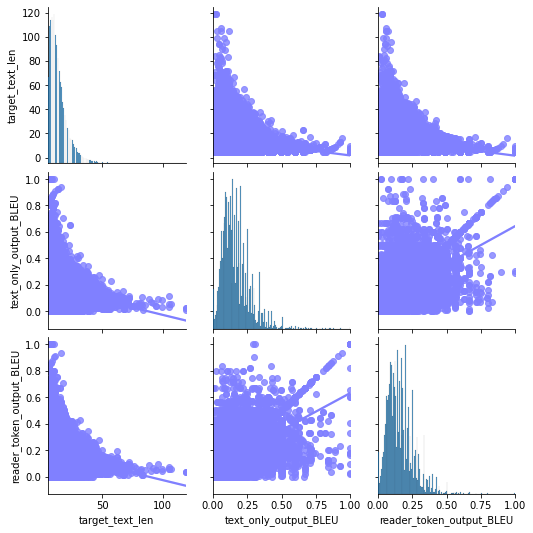

In [8]:
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.pairplot(data=combined_data, vars=['target_text_len', 'text_only_output_BLEU', 'reader_token_output_BLEU'], kind='reg', plot_kws={'color' : (0.5, 0.5, 1.0, 0.25)})
plt.show()

Is there any consistent difference in the correlation between question length and model performance?

In [9]:
from scipy.stats import spearmanr, pearsonr
output_vars = ['text_only_output', 'reader_token_output', 'reader_attn_output', 'reader_text_embed_output', 'reader_subreddit_embed_output']
for output_var in output_vars:
    print(f'testing output = {output_var}')
    correl, p_val = spearmanr(combined_data.loc[:, 'target_text_len'].values, 
                              combined_data.loc[:, f'{output_var}_BLEU'].values)
    print(f'correl = {correl}, p={p_val}')

testing output = text_only_output
correl = -0.09048037182457778, p=2.7442067868441005e-102
testing output = reader_token_output
correl = -0.08701576776926362, p=1.012657436913191e-94
testing output = reader_attn_output
correl = -0.17583784836616295, p=0.0
testing output = reader_text_embed_output
correl = -0.08516400118380464, p=8.46199400615569e-91
testing output = reader_subreddit_embed_output
correl = -0.17826901226160516, p=0.0


In general, all models do worse on longer text. The correlation is less severe for the `reader_token` model and `reader_text_embed_output` model than for others.

### Compare questions: type
Do some models do better with different types of questions (e.g. `how` vs. `why`)?

We need a good way to extract the question word from the subject position, so let's try parsing.

In [12]:
## get children of root word C
## check for valid relations: advmod, dobj, attr
## if none, check for determiners on NPs ("which one"): det, advmod
def get_question_modifiers(parser, sentence, question_words, 
                       question_word_deps={'advmod', 'dobj', 'attr', 'aux'}, determiner_deps={'det', 'advmod'},
                       determiner_attach_deps={'acomp', 'dobj', 'attr'}):
    sentence_parse = parser(sentence)
    sentence_root = list(sentence_parse.sents)[0].root
    root_children = list(sentence_root.children)
    # check for question words in immediate children
    modifier_children = list(filter(lambda x: x.dep_ in question_word_deps, root_children))
    question_modifiers = list(filter(lambda x: x.text.lower() in question_words, modifier_children))
    # check for question words in determiners on children
    if(len(question_modifiers) == 0):
        potential_det_parents = list(filter(lambda x: x.dep_ in determiner_attach_deps, root_children))
        det_children = [y for x in potential_det_parents for y in x.children if y.dep_ in determiner_deps]
        question_det_modifiers = list(filter(lambda x: x.text.lower() in question_words, det_children))
        question_modifiers += question_det_modifiers
    # lower-case everything
    question_modifiers = list(map(lambda x: x.text.lower(), question_modifiers))
    return question_modifiers

In [13]:
import spacy
test_sents = ['How many are there?', 'What is the problem?', 'You are going where?', 'And when are you leaving?']
parser = spacy.load('en_core_web_sm')
question_words = {'how', 'when', 'where', 'what', 'who', 'why', 'which', 'do', 'should', 'could', 'would', 'can'}
for sentence in test_sents:
    sentence_parse = parser(sentence)
    sentence_question_modifiers = get_question_modifiers(parser, sentence, question_words)
    print(sentence_question_modifiers)

['how']
['what']
['where']
['when']


In [14]:
from tqdm import tqdm
tqdm.pandas()
combined_data = combined_data.assign(**{
    'question_word' : combined_data.loc[:, 'target_text'].progress_apply(lambda x: get_question_modifiers(parser, x, question_words))
})
combined_data = combined_data.assign(**{
    'question_word' : combined_data.loc[:, 'question_word'].progress_apply(lambda x: x[0] if len(x) > 0 else 'other')
})
# get word counts
question_word_counts = combined_data.loc[:, 'question_word'].value_counts()
print(question_word_counts)

100%|██████████| 56097/56097 [00:00<00:00, 766617.27it/s]

other     34891
do         6539
what       4555
how        3392
why        2527
would      1528
can        1082
could       528
where       506
should      276
when        228
which        23
who          22
Name: question_word, dtype: int64


Let's see how the different models do on different questions!!

In [15]:
flat_data = pd.melt(combined_data, value_vars=['text_only_output_BLEU', 'reader_token_output_BLEU', 'reader_attn_output_BLEU', 'reader_text_embed_output_BLEU', 'reader_subreddit_embed_output_BLEU'], id_vars=['question_word'], var_name='model_type', value_name='BLEU')
flat_data = flat_data.assign(**{'model_type' : flat_data.loc[:, 'model_type'].apply(lambda x: x.replace('_BLEU', ''))})
display(flat_data.head())

,question_word,model_type,BLEU
0,other,text_only_output,0.100000
1,other,text_only_output,0.101088
2,do,text_only_output,0.048486
3,other,text_only_output,0.083333
4,other,text_only_output,0.300000


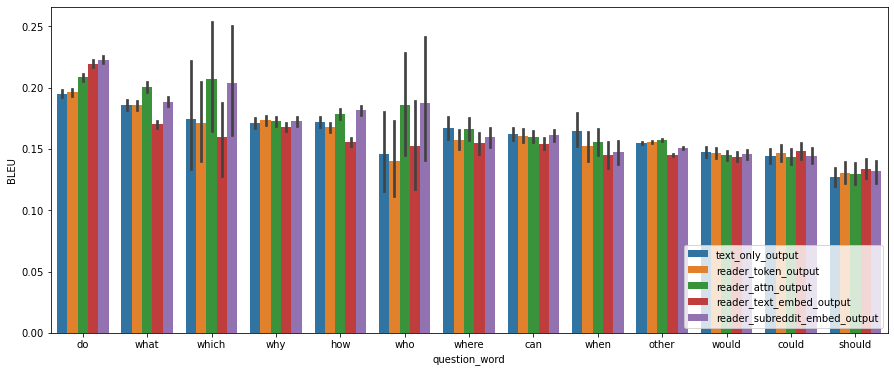

In [16]:
plt.figure(figsize=(15, 6))
sns.barplot(data=flat_data, x='question_word', y='BLEU', hue='model_type', order=sorted(flat_data.loc[:, 'question_word'].unique(), key=lambda x: flat_data[flat_data.loc[:, 'question_word']==x].loc[:, 'BLEU'].mean(), reverse=True))
plt.legend(loc='lower right')
plt.show()

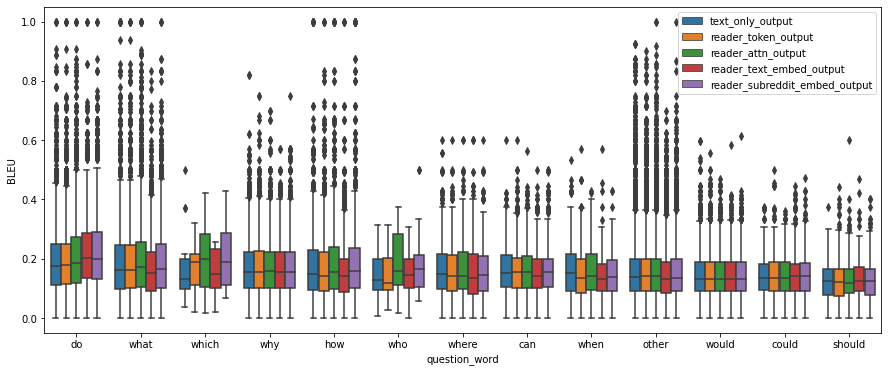

In [17]:
plt.figure(figsize=(15, 6))
sns.boxplot(data=flat_data, x='question_word', y='BLEU', hue='model_type', order=sorted(flat_data.loc[:, 'question_word'].unique(), key=lambda x: flat_data[flat_data.loc[:, 'question_word']==x].loc[:, 'BLEU'].mean(), reverse=True))
plt.legend(loc='upper right')
plt.show()

- All models do well on `do`, `what` questions and poorly on `would`, `should`.
- `text_only` model does better on `when`, `where` questions.
- `reader_token` model does slightly better `why` questions.
- `reader_attn_output` model does better on `what`, `which`, `how` questions.
- `reader_text_embed` and `reader_subreddit_embed` models do better on `do`, `what`, `how` questions.

Let's confirm this result with each type of model on the questions that actually have reader question information.

37273
0.6644383835142699


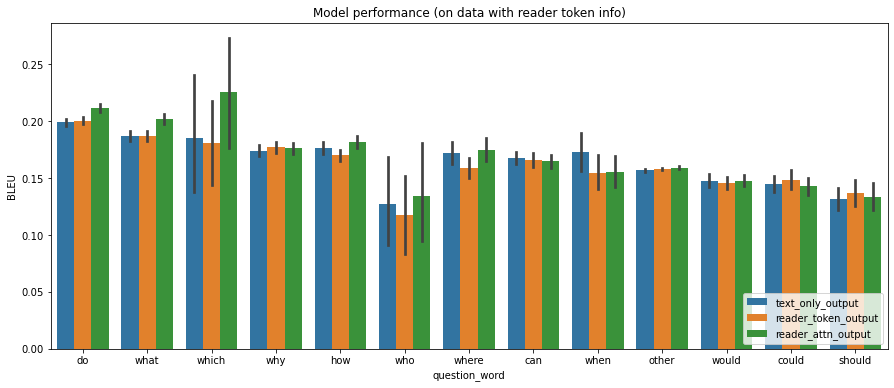

In [18]:
## reader token
combined_data_with_reader_token = combined_data[combined_data.loc[:, 'reader_token']!='UNK']
print(combined_data_with_reader_token.shape[0])
print(combined_data_with_reader_token.shape[0]/combined_data.shape[0])
## re-flatten data
flat_data_with_reader_token = pd.melt(combined_data_with_reader_token, value_vars=['text_only_output_BLEU', 'reader_token_output_BLEU', 'reader_attn_output_BLEU',], id_vars=['question_word'], var_name='model_type', value_name='BLEU')
flat_data_with_reader_token = flat_data_with_reader_token.assign(**{'model_type' : flat_data_with_reader_token.loc[:, 'model_type'].apply(lambda x: x.replace('_BLEU', ''))})
plt.figure(figsize=(15, 6))
sns.barplot(data=flat_data_with_reader_token, x='question_word', y='BLEU', hue='model_type', order=sorted(flat_data.loc[:, 'question_word'].unique(), key=lambda x: flat_data[flat_data.loc[:, 'question_word']==x].loc[:, 'BLEU'].mean(), reverse=True))
plt.legend(loc='lower right')
plt.title('Model performance (on data with reader token info)')
plt.show()

25992
0.4633402855767688


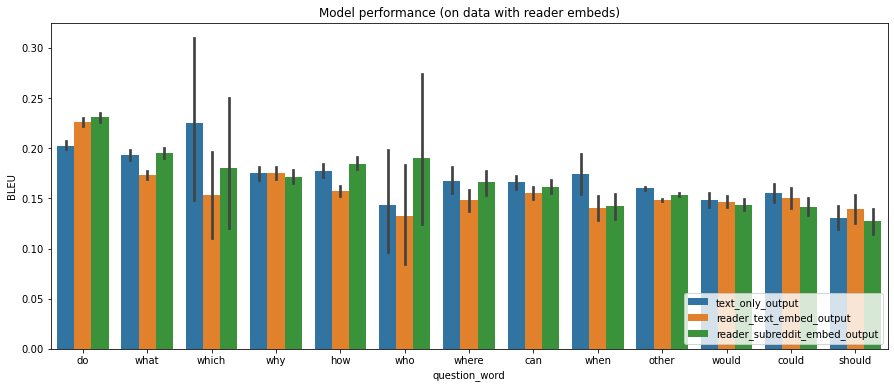

In [19]:
## reader embeds
combined_data_with_embed = combined_data[combined_data.loc[:, 'author_has_subreddit_embed'] & combined_data.loc[:, 'author_has_text_embed']]
print(combined_data_with_embed.shape[0])
print(combined_data_with_embed.shape[0]/combined_data.shape[0])
## re-flatten data
flat_data_with_embed = pd.melt(combined_data_with_embed, value_vars=['text_only_output_BLEU', 'reader_text_embed_output_BLEU', 'reader_subreddit_embed_output_BLEU'], id_vars=['question_word'], var_name='model_type', value_name='BLEU')
flat_data_with_embed = flat_data_with_embed.assign(**{'model_type' : flat_data_with_embed.loc[:, 'model_type'].apply(lambda x: x.replace('_BLEU', ''))})
plt.figure(figsize=(15, 6))
sns.barplot(data=flat_data_with_embed, x='question_word', y='BLEU', hue='model_type', order=sorted(flat_data.loc[:, 'question_word'].unique(), key=lambda x: flat_data[flat_data.loc[:, 'question_word']==x].loc[:, 'BLEU'].mean(), reverse=True))
plt.legend(loc='lower right')
plt.title('Model performance (on data with reader embeds)')
plt.show()

### Test question-post overlap
How much do the questions overlap with the post content?

We can measure this with two metrics:
1. max semantic overlap: find sentence with highest similarity (in sentence embedding) to question
2. topic overlap: compute topic distribution over all posts, compute overall topical alignment with post/question

### Post overlap: semantics

In [20]:
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
def compute_max_sent_overlap(post_text, question_text, sent_tokenizer, sentence_embed_model):
    post_text_sents = sent_tokenizer.tokenize(post_text)
    post_text_sent_embeds = np.array(list(map(lambda x: sentence_embed_model.encode(x), post_text_sents)))
    question_embed = sentence_embed_model.encode(question_text)
    post_text_sent_question_sims = cosine_similarity(post_text_sent_embeds, question_embed.reshape(1,-1))[:, 0]
    max_sim = post_text_sent_question_sims.max()
    max_sim_sent = post_text_sents[post_text_sent_question_sims.argmax()]
    return (max_sim_sent, max_sim)

In [21]:
from sentence_transformers import SentenceTransformer
from nltk.tokenize import PunktSentenceTokenizer
from tqdm import tqdm
tqdm.pandas()
sample_size = 5000
np.random.seed(123)
sample_combined_data = combined_data.loc[np.random.choice(combined_data.index, sample_size, replace=False), :]
target_text_vars = ['target_text', 'text_only_output', 'reader_token_output', 'reader_attn_output', 'reader_text_embed_output', 'reader_subreddit_embed_output']
# target_text_vars = ['target_text']
sentence_embed_model = SentenceTransformer('paraphrase-distilroberta-base-v1')
sent_tokenizer = PunktSentenceTokenizer()
for target_text_var in target_text_vars:
    print(f'testing text={target_text_var}')
    sample_combined_data = sample_combined_data.assign(**{
        f'{target_text_var}_max_sim_sent' : sample_combined_data.progress_apply(lambda x: compute_max_sent_overlap(x.loc['source_text'],  x.loc[target_text_var], sent_tokenizer, sentence_embed_model), axis=1)
    })

  0%|          | 0/5000 [00:00<?, ?it/s]

testing text=target_text


  0%|          | 3/5000 [00:00<03:03, 27.18it/s]

testing text=text_only_output


  0%|          | 3/5000 [00:00<03:00, 27.62it/s]

testing text=reader_token_output


  0%|          | 3/5000 [00:00<02:53, 28.73it/s]

testing text=reader_attn_output


 94%|█████████▎| 4676/5000 [09:55<01:05,  4.98it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

  0%|          | 3/5000 [00:00<03:49, 21.82it/s]

testing text=reader_subreddit_embed_output


100%|██████████| 5000/5000 [10:46<00:00,  7.74it/s]


In [22]:
## separate sents and sim values
for target_text_var in target_text_vars:
    sample_combined_data = sample_combined_data.assign(**{
        f'{target_text_var}_max_sim_sent_val' : sample_combined_data.loc[:, f'{target_text_var}_max_sim_sent'].apply(lambda x: x[1]),
        f'{target_text_var}_max_sim_sent' : sample_combined_data.loc[:, f'{target_text_var}_max_sim_sent'].apply(lambda x: x[0]),
    })

What are some sentences with high post similarity?

In [23]:
max_sim_cutoff_val = 1-1e-3 # removing duplicates
target_text_vars = ['target_text', 'text_only_output', 'reader_token_output', 'reader_attn_output', 'reader_text_embed_output', 'reader_subreddit_embed_output']
for target_text_var_i in target_text_vars:
    # restrict to relevant data
    if(target_text_var in {'reader_token_output', 'reader_attn_output'}):
        sample_combined_data_i = sample_combined_data[sample_combined_data.loc[:, 'reader_token']!='UNK']
    elif(target_text_var in {'reader_text_embed_output', 'reader_subreddit_embed_output'}):
        sample_combined_data_i = sample_combined_data[sample_combined_data.loc[:, 'author_has_subreddit_embed'] & sample_combined_data.loc[:, 'author_has_text_embed']]
    else:
        sample_combined_data_i = sample_combined_data.copy()
    display(sample_combined_data_i[sample_combined_data_i.loc[:, f'{target_text_var_i}_max_sim_sent_val']<=max_sim_cutoff_val].sort_values(f'{target_text_var_i}_max_sim_sent_val', inplace=False, ascending=False).loc[:, ['source_text', 'target_text', f'{target_text_var_i}_max_sim_sent', f'{target_text_var_i}_max_sim_sent_val', target_text_var_i]].head(10))
    display(sample_combined_data_i[sample_combined_data_i.loc[:, f'{target_text_var_i}_max_sim_sent_val']<=max_sim_cutoff_val].sort_values(f'{target_text_var_i}_max_sim_sent_val', inplace=False, ascending=True).loc[:, ['source_text', 'target_text', f'{target_text_var_i}_max_sim_sent', f'{target_text_var_i}_max_sim_sent_val', target_text_var_i]].head(10))

,source_text,target_text,target_text_max_sim_sent,target_text_max_sim_sent_val,target_text
11350,"Greetings all. My father had surgery a few years ago for a facial tick. The tick was fixed, but he lost hearing in one ear a few months afterwards. The surgery was performed below that same ear as evidenced by the giant (albeit cool) scar he has from the surgery.However, whenever he tries to contact malpractice lawyers about his case they seem to all come back relatively quickly with a tepid response. We don't ever get a real answer on why they can't take the case as they say it's just not something they really handle. This seems to be whenever they find out which hospital the surgery came from and whom the surgeon was (the surgeon seems to have a clean record and has been in practice for some time). For the record, the surgery was in Jacksonville and I can say the name of the hospital if it's needed/allowed.I know this isn't the place to try and get someone to take his case and I haven't detailed the specifics of the procedure, but it seems at least someone would hear him out (cau...",Have you went to another doctor that has actually diagnosed the cause for the hearing loss?,Is there an avenue we can take to see if the surgery and hearing loss was related?,0.742708,Have you went to another doctor that has actually diagnosed the cause for the hearing loss?
31921,I'm in a terrible pattern of sleeping. I go to bed at midnight and wake up at 5. It's got to the point I'm that awake I get up and do my house chores. But I'm no more tired come night time. I'd love to get 7 hours sleep. If I go to bed earlier I wake up even earlier...,Do you wake up at 5am or 5pm?,I go to bed at midnight and wake up at 5.,0.733412,Do you wake up at 5am or 5pm?
49542,I played black ops 3 on pc with a 360 controller on my oled c7 and it was lagy as in had input lag which never happened on my ps4. My tv has a 21 ms input lag. How much do i need for it not to be lagy anymore or is this because of something else and not the tv? Is everyones game lagy when played with a controller on pc? What is the problem here?,Is everything fine on screen but when you hit the buttons on the controller it's delayed?,Is everyones game lagy when played with a controller on pc?,0.728188,Is everything fine on screen but when you hit the buttons on the controller it's delayed?
48170,"I’m no longer with my spouse for several years but have not filed the paperwork for divorce. Just didn’t get around to it so legally I’m still married but no longer together. If I put down single for the w4 on employment paperwork, would there be any legal issues? Can I put down single but when filing taxes file it as married? This is California",Are you filing your taxes jointly with your spouse?,Can I put down single but when filing taxes file it as married?,0.724605,Are you filing your taxes jointly with your spouse?
14002,"I need some help as to what steps to make next.Back in August I noticed a small charge of about $2 at a hotel that wasn't me and it was in another city. I called the bank and immediately got my card replaced. Some days later, I get $2300 withdrawn from my account due to a charge back for a fraud check. Someone in another city, went to a atm and cashed a fake check using my account. Somehow someone got a copy of my debit card and my pin and cashed the check. I still have my old debit card.The bank opened a claim and 60 days later they closed it saying that because my debit card and pin number was used, they denied my claim.I live paycheck to paycheck and $2300 is A LOT OF MONEY for me to give up. It will break me.The bank is bank of america and I've spoken to 3 people, 2 being managers and they all say the same thing, because you failed to safe guard your information, you are at fault.I'm the type who always check for skimmer devices at gas stations, block my pin when entering it......","So, someone cashed a fraudulent check at an ATM using your debit card and PIN?",Somehow someo

,source_text,target_text,target_text_max_sim_sent,target_text_max_sim_sent_val,target_text
7870,"I got a rare medical condition through which my body never fully masculinized, i would need 100k for serveral plastic surgeries to fix my physical Syndromes",Do you mean a loan?,"I got a rare medical condition through which my body never fully masculinized, i would need 100k for serveral plastic surgeries to fix my physical Syndromes",-0.025441,Do you mean a loan?
9408,"Ik this is kinda offtopic but I need someone’s experience with the windows 10 network issues, I can’t find any networks and my WiFi icon at the toolbar is gone .. I literally tried everything on YouTube from updating/reinstalling my network adapters to restoring network settings But it’s all useless My network discovery option was off so I turned it on and it still doesn’t work .Anyone familiar with this error.Note:I literally tried everything please help",Where are you getting the drivers from?,"Ik this is kinda offtopic but I need someone’s experience with the windows 10 network issues, I can’t find any networks and my WiFi icon at the toolbar is gone .. I literally tried everything on YouTube from updating/reinstalling my network adapters to restoring network settings But it’s all useless My network discovery option was off so I turned it on and it still doesn’t work .Anyone familiar with this error.Note:I literally tried everything please help",-0.014119,Where are you getting the drivers from?
18978,"Since we don't know when 2070 is going to be released, and with the recent Nvidia's benchmarks of 2080 (which basically are 20+ fps bonus when put against a 1080) , I see less and less reason to wait for it and hope that it will be better than a 1080 (in regular games, ray tracing lmao no ty).",Why do people keep asking this stupid question?,"Since we don't know when 2070 is going to be released, and with the recent Nvidia's benchmarks of 2080 (which basically are 20+ fps bonus when put against a 1080) , I see less and less reason to wait for it and hope that it will be better than a 1080 (in regular games, ray tracing lmao no ty).",0.003568,Why do people keep asking this stupid question?
1128,(also a minor) will just leaving a paper on me that has what I want done with all my stuff with my signature okay? would I not be able to have one since I'm under 18?Edit: What the procedure be to make a legal will without going through some sort of attorney /lawyer?Also throw away account because reasons,Know why there are a gazillion numbers?,(also a minor) will just leaving a paper on me that has what I want done with all my stuff with my signature okay?,0.006520,Know why there are a gazillion numbers?
51368,"Hey guys,I have a quick questionI'm trying to ""upgrade"" an old system:Operating System: Windows 8.1 Pro 64-bitCPU: Intel Core i3 4130 @ 3.40GHz\t\tHaswell 22nm TechnologyRAM: 4.00GB Single-Channel DDR3 @ 798MHz (11-11-11-28)Motherboard: Gigabyte B85M-HD3 Graphics: SyncMaster (1680x1050@60Hz)\t Intel HD Graphics 4400 (Gigabyte)Storage: 232GB Seagate ST250DM000-1BD141 (SATA )\tOptical Drives: HL-DT-ST DVDRAM GSA-H60NAudio:Realtek High Definition Audio-----------------------------------------------I bought an H110M-K mobo and a i3-6100 processor + a gtx 1050ti 4gb ddr4 + 8gb of DDR4 ramMy question is whether I can simply take out the old motherboard and replace it with the new one with the CPU already installed on it and put the GPU in and leave the rest as it is, just put all the cables back in the new mobo..should that work or am I supposed to do some things before all of this?Thanks in advance",Why did you buy this ?,"Hey guys,I have a quick questionI'm trying to ""upgrade"" an old system:Operating System: Windows 8.1 Pro 64-bitCPU: Intel Core i3 4130 @ 3.40GHz\t\tHaswell 22nm TechnologyRAM: 4.00GB Single-Channel DDR3 @ 798MHz (11-11-11-28)Motherboard: Gigabyte B85M-HD3 Graphics: SyncMaster (1680x1050@60Hz)\t Intel HD Graphics 4400 (Gigabyte)Storage: 232GB Seagate ST

,source_text,target_text,text_only_output_max_sim_sent,text_only_output_max_sim_sent_val,text_only_output
15019,What are my options? Moving to my own place and I only need a few channels for sure:HallmarkCNNTLCand don’t want to pay $116 a month to cable. I think I have a smart TV - but if not I’ll buy one. Plz send hack ideas!,Where are you located?,What are my options?,0.949810,What are your options?
31928,So after changing jobs from time to time over the past 20 years I now find myself with 5 different 401Ks. I know I should probably roll at least some of them over into my current retirement plan.. is it better to roll over everything? Some things? The ones with the larger balances? The smaller balances? Something else?,What are the tickers available to you in your current 401k plan?,The smaller balances?,0.918431,What are the smaller balances?
15138,"I'll keep this brief. My girlfriend was visiting a friend in Virginia and got pulled over for going 85 mph in a 70 mph zone on the highway. In Virginia, going faster than 80 mph is an automatic reckless driving charge, and that's what the officer cited her for. She has a mandatory court date coming up, so she'll have to go back to Virginia for her court appearance. She's been freaking out nonstop ever since, because she can't afford a lawyer (we're both college students) and she's scared having a misdemeanor on her record is going to hurt her future job chances. She claims she had no idea she could be criminally charged for going more than 80 mph and that she was just going at the speed of traffic. I told her if she hadn't been driving way over the speed limit (seriously, 15 mph?), she wouldn't be in this situation in the first place. She could have seriously hurt somebody going that fast. She's upset that I'm not more sympathetic toward her situation, but I think it's pretty clear...","I mean you're right, but would you rather be right or have a girlfriend?","I told her if she hadn't been driving way over the speed limit (seriously, 15 mph?",0.785142,INFO: How do you know she wasn’t going 15 mph over the speed limit?
48251,"AMIA for not wanting to help my mom pay the bills?So I (17f) just started my job for the first time. I get paid weekly and I work 3 days a week, 6 hours a day, $8 an hour. My mom recently moved away from my dad and is taking care of me and my brother alone. I don’t have my own card yet and when asked for it, she told me that she would let me get one but I would have to pay my brother’s daycare bill ($200). Earlier that day she asked to borrow some money from me when she found out I got $30 in total from tip. She’s had a history of “holding” my money for me. Although I would help her, I also want to be able to have spending money for myself too. I definitely wouldn’t be so hesitant if she had asked first if I could help pay bills instead of demanding me to do it if I wanted a card. As it is right now I’m really annoyed and unsure if I want to pay that $200. Am I the asshole?",Does your mom work?,My mom recently moved away from my dad and is taking care of me and my brother alone.,0.778907,Your mom moved away from your dad and your brother still took care of you?
54009,"Our landlord has called us and announced that he wanted to sell the apt we live in. Hubby (before he was hubby) signed a lease eight years ago, I moved in six years ago. The lease renewed to year-to-year. Always - twelve month renewal at the end of the term. No month to month. We tried a few years ago to go month to month but he refused. &amp;#x200B;He called us on 3/2 to tell us he wants to sell - nothing in writing (as lease requires) our lease ends 6/30. In that phone call, LL announces that he is reserving every weekend (starting this weekend) every Friday, Saturday, and Sunday and 'at least one weekday' every week for showings through June 30. This is a problem - calling 'dibs' on every weekend and 'at least one weekday' for the next 17 weekends/4 months is pretty awful, and not really re

,source_text,target_text,text_only_output_max_sim_sent,text_only_output_max_sim_sent_val,text_only_output
51368,"Hey guys,I have a quick questionI'm trying to ""upgrade"" an old system:Operating System: Windows 8.1 Pro 64-bitCPU: Intel Core i3 4130 @ 3.40GHz\t\tHaswell 22nm TechnologyRAM: 4.00GB Single-Channel DDR3 @ 798MHz (11-11-11-28)Motherboard: Gigabyte B85M-HD3 Graphics: SyncMaster (1680x1050@60Hz)\t Intel HD Graphics 4400 (Gigabyte)Storage: 232GB Seagate ST250DM000-1BD141 (SATA )\tOptical Drives: HL-DT-ST DVDRAM GSA-H60NAudio:Realtek High Definition Audio-----------------------------------------------I bought an H110M-K mobo and a i3-6100 processor + a gtx 1050ti 4gb ddr4 + 8gb of DDR4 ramMy question is whether I can simply take out the old motherboard and replace it with the new one with the CPU already installed on it and put the GPU in and leave the rest as it is, just put all the cables back in the new mobo..should that work or am I supposed to do some things before all of this?Thanks in advance",Why did you buy this ?,"Hey guys,I have a quick questionI'm trying to ""upgrade"" an old system:Operating System: Windows 8.1 Pro 64-bitCPU: Intel Core i3 4130 @ 3.40GHz\t\tHaswell 22nm TechnologyRAM: 4.00GB Single-Channel DDR3 @ 798MHz (11-11-11-28)Motherboard: Gigabyte B85M-HD3 Graphics: SyncMaster (1680x1050@60Hz)\t Intel HD Graphics 4400 (Gigabyte)Storage: 232GB Seagate ST250DM000-1BD141 (SATA )\tOptical Drives: HL-DT-ST DVDRAM GSA-H60NAudio:Realtek High Definition Audio-----------------------------------------------I bought an H110M-K mobo and a i3-6100 processor + a gtx 1050ti 4gb ddr4 + 8gb of DDR4 ramMy question is whether I can simply take out the old motherboard and replace it with the new one with the CPU already installed on it and put the GPU in and leave the rest as it is, just put all the cables back in the new mobo..should that work or am I supposed to do some things before all of this?Thanks in advance",-0.088304,How do you plan on doing this?
33183,[PC Part Picker](https://pcpartpicker.com/user/BananaBoy63847/saved/#view=s8QCbv),So... what are your goals with this machine ?,[PC Part Picker](https://pcpartpicker.com/user/BananaBoy63847/saved/#view=s8QCbv),-0.029026,Do you have a budget?
40352,Every night after I can’t fall asleep I always worry that I won’t be able to sleep that night either. It doesn’t help that I have finals coming up and friend drama also going with that. I have tried meditation but I can’t de stress and fall asleep.,How is it involving you in it?,It doesn’t help that I have finals coming up and friend drama also going with that.,0.005639,What do you think of that?
34414,The calls and texts are great but it aches that I can't be with her in real life.,Any chance of you two meeting in real life?,The calls and texts are great but it aches that I can't be with her in real life.,0.012772,What do you want?
52387,"Hello everyone, I was recently HWID banned from fortnite because I had a CSGO injector on my computer. I really want to play fortnite and I don't want to buy a new PC.","No one wants to help you, why would we help a cheater get back into games?","Hello everyone, I was recently HWID banned from fortnite because I had a CSGO injector on my computer.",0.016398,Do you have a job or something?
22718,"Is it okay to hate your girlfriends ex? I mean they are just friends, but I absolutely hate the asshole. I never met him nor do I ever want him in her life but damn. I hate him",just cause he fucked your girl?,Is it okay to hate your girlfriends ex?,0.019846,How do you know what's going on?
31399,"Hello , I’ve been dealing with a mental issue where my thoughts tell me to do something I don’t want to do for example I get a thought to throw my phone at the ground, These thoughts escalated to harming animals or humans or even myself. This issue sent me down a depressive spiral, please help.","Go to school, go to a social worker or teacher and go just go ""Hey, can i talk to you for a sec?","This

,source_text,target_text,reader_token_output_max_sim_sent,reader_token_output_max_sim_sent_val,reader_token_output
15019,What are my options? Moving to my own place and I only need a few channels for sure:HallmarkCNNTLCand don’t want to pay $116 a month to cable. I think I have a smart TV - but if not I’ll buy one. Plz send hack ideas!,Where are you located?,What are my options?,0.949810,What are your options?
41091,"I just started my freshman year of high school and starting last year in middle school I've been obsessed with getting a girlfriend. I don't know why I care so much, because I basically just imagine myself doing stuff with girls, which I would normally do with friends (with the odd but of handholding). I hate to seem emo because I think I'm a pretty cheerful happy guy in general, but it's gotten to the point where if I see a freshman couple in the hallway or see pictures of other freshman in relationships I get sad. I feel really anxious about the that I don't have a girlfriend, because I'm very average in looks and whatnot and I perform well academically, and Im not bothered by who it is as long as I can have the authentic boyfriend-girlfriend relationship, so I don't see any distinct disadvantages that I have. I've now asked out 15 girls I've known over the course of 8th and 9th grade. What can I do to further increase my chances of getting a girlfriend or stop being bothered by...",what are your goals?,What can I do to further increase my chances of getting a girlfriend or stop being bothered by not having one?,0.798778,Are you doing anything to increase your chances of finding a girlfriend?
15138,"I'll keep this brief. My girlfriend was visiting a friend in Virginia and got pulled over for going 85 mph in a 70 mph zone on the highway. In Virginia, going faster than 80 mph is an automatic reckless driving charge, and that's what the officer cited her for. She has a mandatory court date coming up, so she'll have to go back to Virginia for her court appearance. She's been freaking out nonstop ever since, because she can't afford a lawyer (we're both college students) and she's scared having a misdemeanor on her record is going to hurt her future job chances. She claims she had no idea she could be criminally charged for going more than 80 mph and that she was just going at the speed of traffic. I told her if she hadn't been driving way over the speed limit (seriously, 15 mph?), she wouldn't be in this situation in the first place. She could have seriously hurt somebody going that fast. She's upset that I'm not more sympathetic toward her situation, but I think it's pretty clear...","I mean you're right, but would you rather be right or have a girlfriend?","I told her if she hadn't been driving way over the speed limit (seriously, 15 mph?",0.785142,INFO: How do you know she wasn’t going 15 mph over the speed limit?
35613,"I’m skipping school, and my parents are not happy with meI haven't been attending school much lately. I am a 15-year-old Swede who has approximately 32 days of primary school left. I have tremendous anxiety sitting in class. That is the primary reason as to why I haven't been attending school much lately. I also am sick quite a lot, like the common cold keeps coming back to me. I've been sick like four times this year, and it's only been four months. The problem is that I don't know if that's a valid excuse to not be in school, and I feel bad when I stay at home. I suppose it may just be an excuse for me not to be in school, though.I'm skipping school right now. My left ear is not feeling very well, but maybe that's not an excuse. I kind of have the common cold, but maybe that's not an excuse.",Why are you anxious about going to school?,I have tremendous anxiety sitting in class.,0.773337,So you have anxiety sitting in class?
42105,"Hey all! I'm applying to grad school, and (hopefully, fingers crossed!) I will be starting in fall 2019. I've been employed making around 38k annually before tax. My 

,source_text,target_text,reader_token_output_max_sim_sent,reader_token_output_max_sim_sent_val,reader_token_output
27880,"I can't think of a single reason to buy a Radeon VII as a gamer when I can buy a 2080 for the same price.The VII isn't really overklockable, doesn't support any of Nvidia's features, draws more power, runs hotter, and is louderThis card seems really useless to me, it seems like a 1080ti competitor launched a few years too late",You have a Freesync 2 monitor and Nvidia's drivers aren't fully fleshed out for it?,"I can't think of a single reason to buy a Radeon VII as a gamer when I can buy a 2080 for the same price.The VII isn't really overklockable, doesn't support any of Nvidia's features, draws more power, runs hotter, and is louderThis card seems really useless to me, it seems like a 1080ti competitor launched a few years too late",-0.112857,What's your budget?
30984,except for Corsair Obsidian Series 1000D which is crazy expensive something for 100 to 250 $ and available worldwide.,Do you want dual ATX or ATX + mATX?,except for Corsair Obsidian Series 1000D which is crazy expensive something for 100 to 250 $ and available worldwide.,-0.038165,What do you have now?
33183,[PC Part Picker](https://pcpartpicker.com/user/BananaBoy63847/saved/#view=s8QCbv),So... what are your goals with this machine ?,[PC Part Picker](https://pcpartpicker.com/user/BananaBoy63847/saved/#view=s8QCbv),-0.037113,Where do you live?
52387,"Hello everyone, I was recently HWID banned from fortnite because I had a CSGO injector on my computer. I really want to play fortnite and I don't want to buy a new PC.","No one wants to help you, why would we help a cheater get back into games?","Hello everyone, I was recently HWID banned from fortnite because I had a CSGO injector on my computer.",-0.036825,What is your budget?
52016,"This really does seem like a yearly thing that happens to me, I let my thoughts go on for to long and start to have an existential crisis, it's like I feel like im controlling myself, but I'm not at the same time, and I have a hard time living in the present, it's hard to explain but any form of advice is helpful because I really don't wanna live my life like this.",Can you describe what exactly your existential thoughts are?,"This really does seem like a yearly thing that happens to me, I let my thoughts go on for to long and start to have an existential crisis, it's like I feel like im controlling myself, but I'm not at the same time, and I have a hard time living in the present, it's hard to explain but any form of advice is helpful because I really don't wanna live my life like this.",-0.027206,How old are you?
53385,I saw on his Instagram he has been liking and commenting on other women's pictures in the meantime 😞,Did he read your last message of ghost you ?,I saw on his Instagram he has been liking and commenting on other women's pictures in the meantime 😞,-0.011464,What's the context for this?
41788,"Ok so I’m on mobile just a disclaimer,Now this happened a year ago , I (16m) and two of of my friends , sam (17m) and tyrone (17m), we had an argument about what game will win GOTY 2018 , i said god of war ,sam said red dead 2 and tyrone said spiderman.At first i thought it was just a simple argument but then they decided we should bet 10$ each on it , i agreed and we all shook on it( in our friend group handshakes are sacred) so the GOTY awards roll around and god of war won, i was so happy not because of the money but because god of war is an amazing game , so i text them reminding them of the bet they straight up say “ if kratos comes to my house in a suit and threatens me i still wouldn’t give you the money” i thought they were joking , they weren’t, i told them that we shook on it and kept talking about it for the last month , they said they were joking about the bet , i blocked them and avoided them in school completely .... AITA for doing that, did i overreact, I’m 100% sure...",It’s $20 bucks but is $20

,source_text,target_text,reader_attn_output_max_sim_sent,reader_attn_output_max_sim_sent_val,reader_attn_output
27365,"My credit isn't great and I pay nearly 300 a month for my student loans, pay about 150 for phone bill, and around 160 for car insurance. What would I need to be eligible for income based repayment for student loans? What can I do to haggle with phone carriers? I'm new to adulting. Any starting advice would be perfect. Thank you so much.",Are you paying for insurance that you don't need or will ever use?,What would I need to be eligible for income based repayment for student loans?,0.729734,What are the interest rates on your student loans?
7457,Neither my wifes job nor mine offer a 401k but both pay us fairly well. Whats the best course of action for creating a 401k for us?,Do you have an IRA (Traditional or Roth)?,Whats the best course of action for creating a 401k for us?,0.720904,Do you have a 401k at your current employer?
21742,"Hello all, im a 14 year old girl and im currently in high school. I made this account as a way to vent my feelings. If this post is not appropriate, feel free to remove but please direct me to a subreddit where i can talk about it. Since you guys are teenagers too i suppose, i can talk to you about this i guess. My parents are all good but sometimes they have very physical fights. They both hit each other and most of the time it is too violent for me to control. Things usually calm down after a day or two. I also have a younger sister (she's 5) and i usually go out of the house with her whenever the fights happen. Also my parents are kind of conservative in nature, i dont know how they would feel if i told them that i liked girls too. Ive never dated anyone but ive had a fair amount of crushes. At my school, if it were to get out that i was bi, then id be shunned and shamed about how it isnt right. I dont really have friends and the ones that i have are mostly extremely toxic in na...",Does your school offer a counselling service?,"Hello all, im a 14 year old girl and im currently in high school.",0.682002,Are you in high school?
31084,"My older sister is getting ready to have kids. She’s talked about baby names and I was surprised to hear her plans. A little background: i got my middle name from my mom. My older sister has her own original first and middle names and I was given my mom’s middle name as my middle name. To clarify, let’s say my mom’s middle name is Alice. My sister is not named after Alice. My middle name is Alice. I know from previous conversations that I got Alice because my parents couldn’t think of anything they liked and my aunt suggested passing down the middle name.I have always had intentions on passing Alice as my first daughter’s middle name. I don’t know if my sister knows this. She wants to name her first girl something like Haley Alice Lastname but definitely Alice for the middle name. This BOTHERS me. I know it may be petty but I need to decide if I’m going to let this bother me or not. It my name; it’s not her name. She’s older and my parents chose her name on simply names they liked—...",Instead of being resentful why don’t you look at it another way?,My older sister has her own original first and middle names and I was given my mom’s middle name as my middle name.,0.656548,"INFO: Are you the middle name name, or has your sister ever done anything to name your sister’s name?"
51666,"Hi, I’m very sorry if this is not the right sub for this kind of question. Last night I decided to subscribe to a premium Snapchat account that was advertised as a one time payment of $9.95. Well there’s a saying about something sounding too good to be true, because after I submitted the payment, I went back and noticed the fine print, which included automatic subscriptions to 3 other accounts all at $50/month each. I definitely can’t afford to spend $150/month on something like that. The website gave an email address to contact about account cancellation, and I emailed t

,source_text,target_text,reader_attn_output_max_sim_sent,reader_attn_output_max_sim_sent_val,reader_attn_output
27880,"I can't think of a single reason to buy a Radeon VII as a gamer when I can buy a 2080 for the same price.The VII isn't really overklockable, doesn't support any of Nvidia's features, draws more power, runs hotter, and is louderThis card seems really useless to me, it seems like a 1080ti competitor launched a few years too late",You have a Freesync 2 monitor and Nvidia's drivers aren't fully fleshed out for it?,"I can't think of a single reason to buy a Radeon VII as a gamer when I can buy a 2080 for the same price.The VII isn't really overklockable, doesn't support any of Nvidia's features, draws more power, runs hotter, and is louderThis card seems really useless to me, it seems like a 1080ti competitor launched a few years too late",-0.112857,What's your budget?
18978,"Since we don't know when 2070 is going to be released, and with the recent Nvidia's benchmarks of 2080 (which basically are 20+ fps bonus when put against a 1080) , I see less and less reason to wait for it and hope that it will be better than a 1080 (in regular games, ray tracing lmao no ty).",Why do people keep asking this stupid question?,"Since we don't know when 2070 is going to be released, and with the recent Nvidia's benchmarks of 2080 (which basically are 20+ fps bonus when put against a 1080) , I see less and less reason to wait for it and hope that it will be better than a 1080 (in regular games, ray tracing lmao no ty).",-0.067761,What is your budget?
53385,I saw on his Instagram he has been liking and commenting on other women's pictures in the meantime 😞,Did he read your last message of ghost you ?,I saw on his Instagram he has been liking and commenting on other women's pictures in the meantime 😞,-0.064158,Why would you do that?
30984,except for Corsair Obsidian Series 1000D which is crazy expensive something for 100 to 250 $ and available worldwide.,Do you want dual ATX or ATX + mATX?,except for Corsair Obsidian Series 1000D which is crazy expensive something for 100 to 250 $ and available worldwide.,-0.052700,What are you trying to accomplish?
26845,"I realised on the CV I sent to a company which I got a job offer from that I had a typo on the start date of my last job , it’s off by 5 months and I am worried about the discrepancy, I believe they’re already doing the reference checks, should I sent them an email explaining this? I’m starting on Monday and I’m scared they may revoke the offer because the dates won’t match with what my old employer may send back",Hmm.. How significant is this error?,I’m starting on Monday and I’m scared they may revoke the offer because the dates won’t match with what my old employer may send back,-0.048968,What state are you in?
29888,"I have a learning disability (adhd that puts me on the autism spectrum) and it makes it hard to explain stuff, i switch words around and fail to find the right ones when i really need it. My mom is overall supportive but she said i can't start to transition till i finish highschool (2 years). The dysphoria's been hitting really hard lately its almost unbearable.",Have you discussed with a doctor or gender therapist yet?,"I have a learning disability (adhd that puts me on the autism spectrum) and it makes it hard to explain stuff, i switch words around and fail to find the right ones when i really need it.",-0.035158,Have you looked into that?
52016,"This really does seem like a yearly thing that happens to me, I let my thoughts go on for to long and start to have an existential crisis, it's like I feel like im controlling myself, but I'm not at the same time, and I have a hard time living in the present, it's hard to explain but any form of advice is helpful because I really don't wanna live my life like this.",Can you describe what exactly your existential thoughts are?,"This really does seem like a yearly thing that happens to me, I let my thoughts go on for to 

,source_text,target_text,reader_text_embed_output_max_sim_sent,reader_text_embed_output_max_sim_sent_val,reader_text_embed_output
18896,"Help me stop overthinking this... currently saving for a house, and the target number seems to keep getting larger and larger. Let’s say you’re buying $180,000 house: 20% down payment: $36,0002%-5% closing costs: $3,600-$9,0003-6 months emergency fund: $7,500-$15,000Plus, you figure you’ll want some money for new furniture, paint, little stuff new houses might need: idk... $500-$5,000? Low end grand total: $47,600. High end grand total: $65,000. I tend to over estimate everything so, I’m leaning toward the higher side, but then I think “what if something goes wrong - a true emergency! And I drop to 3 months instead of 6, and it’s not enough! What then!”Dramatics aside, when did you feel comfortable buying? How do you know when enough is enough? Can I go a year early, and only put 10% down, assuming low property taxes and a secure job, with an emergency fund of 6 months? Should I only go with a three month emergency fund to put more down? Should I wait the extra year to year and hal...",Whats your credit like?,Should I only go with a three month emergency fund to put more down?,0.741528,Do you have an emergency fund for 3-6 months of expenses?
4014,"Basically what the title says - I'm looking for advice/insight about whether or not to contact an attorney about this. Please bear with me for the long explanation of what I know and who I've already spoken to about this.I bought a house March 2017 and the yard floods VERY badly when it rains. Last night I went to bed and there was snow on the ground - it rained over night (and the snow melted) and this is what my yard looked like this morning. https://i.imgur.com/mMXyC32.jpgThis is not the first time this has happened. I take pictures pretty much every time, and I have about 10. The yard drains, but depending on the day it could take 12 hours or so. It has been raining all day (I took the picture around 6am) and my yard is still flooded as much as in the picture (it is now 6pm).**Who I've talked to:**- The first time it happened I contacted the attorney I used when I purchased the house (and sent pictures) and he brushed me off. He said ""lots of houses flood in the spring when it ...",What specific line of your disclosure form do you feel they were not honest with?,Property?,0.688487,?
15892,"So about 3 months ago I moved in with this girl about 5 years older than me. She had just purchased a condo and was looking to rent a room in it. She seemed so sweet at the beginning. She told me that she wanted me to be comfortable and let her know anything. But then about a month ago she changed. She sent me this huge message out of nowhere with all of the reasons I’m being a bad roommate and everything I’m doing wrong. And the list was majorly exaggerated, false, or just very small things that she made into a big deal. I have since worked very hard to please her and not do anything to make her mad. Her message was very harsh. I feel really tense in the place and don’t even feel super comfortable cooking in fear of doing something on accident she has a problem with. The stress and everything has made me lose weight. And about a week ago I realized I was going to be a little short on rent. I told her this and told her I could pay her what I had, gave her a set date when I could pa...",What are the terms of your signed lease?,What should I do?,0.624909,What are you going to do with it?
27934,Im currently signing up for my 401k at [jhgoenroll.com](https://jhgoenroll.com)and there is a selected investment that i cannot get out of: 100% **JH Multi-Index LS Conserv**&amp;#x200B;What is this? and does that mean the 401k money wont go to me but go to that as an investment?,Can you click into the 100% and change it to 0 or another number?,and does that mean the 401k money wont go to me but go to that as an investment?,0.623538,Do you have a 401k through work?
45698

,source_text,target_text,reader_text_embed_output_max_sim_sent,reader_text_embed_output_max_sim_sent_val,reader_text_embed_output
39574,\[PCPartPicker Part List\]([https://pcpartpicker.com/list/fQtsw6](https://pcpartpicker.com/list/fQtsw6))&amp;#x200B;Type|Item|Price:----|:----|:----\*\*CPU\*\* | \[Intel - Core i5-9600K 3.7 GHz 6-Core Processor\]([https://pcpartpicker.com/product/28qhP6/intel-core-i5-9600k-37ghz-6-core-processor-bx80684i59600k](https://pcpartpicker.com/product/28qhP6/intel-core-i5-9600k-37ghz-6-core-processor-bx80684i59600k)) | $249.89 @ OutletPC \*\*CPU Cooler\*\* | \[Cooler Master - Hyper 212 RGB Black Edition 57.3 CFM CPU Cooler\]([https://pcpartpicker.com/product/hHDJ7P/cooler-master-hyper-212-rgb-black-edition-573-cfm-cpu-cooler-rr-212s-20pc-r1](https://pcpartpicker.com/product/hHDJ7P/cooler-master-hyper-212-rgb-black-edition-573-cfm-cpu-cooler-rr-212s-20pc-r1)) | $38.69 @ Amazon \*\*Motherboard\*\* | \[\\\*ASRock - Z390 Phantom Gaming 4 ATX LGA1151 Motherboard\]([https://pcpartpicker.com/product/ntyV3C/asrock-z390-phantom-gaming-4-atx-lga1150-motherboard-z390-phantom-gaming-4](https://pcpartp...,One question tough... Why is the most expensive component the storage?,\[PCPartPicker Part List\]([https://pcpartpicker.com/list/fQtsw6](https://pcpartpicker.com/list/fQtsw6))&amp;#x200B;Type|Item|Price:----|:----|:----\*\*CPU\*\* | \[Intel - Core i5-9600K 3.7 GHz 6-Core Processor\]([https://pcpartpicker.com/product/28qhP6/intel-core-i5-9600k-37ghz-6-core-processor-bx80684i59600k](https://pcpartpicker.com/product/28qhP6/intel-core-i5-9600k-37ghz-6-core-processor-bx80684i59600k)) | $249.89 @ OutletPC \*\*CPU Cooler\*\* | \[Cooler Master - Hyper 212 RGB Black Edition 57.3 CFM CPU Cooler\]([https://pcpartpicker.com/product/hHDJ7P/cooler-master-hyper-212-rgb-black-edition-573-cfm-cpu-cooler-rr-212s-20pc-r1](https://pcpartpicker.com/product/hHDJ7P/cooler-master-hyper-212-rgb-black-edition-573-cfm-cpu-cooler-rr-212s-20pc-r1)) | $38.69 @ Amazon \*\*Motherboard\*\* | \[\\\*ASRock - Z390 Phantom Gaming 4 ATX LGA1151 Motherboard\]([https://pcpartpicker.com/product/ntyV3C/asrock-z390-phantom-gaming-4-atx-lga1150-motherboard-z390-phantom-gaming-4](https://pcpartp...,-0.137421,How do you plan to save for the next 10-20 years?
18978,"Since we don't know when 2070 is going to be released, and with the recent Nvidia's benchmarks of 2080 (which basically are 20+ fps bonus when put against a 1080) , I see less and less reason to wait for it and hope that it will be better than a 1080 (in regular games, ray tracing lmao no ty).",Why do people keep asking this stupid question?,"Since we don't know when 2070 is going to be released, and with the recent Nvidia's benchmarks of 2080 (which basically are 20+ fps bonus when put against a 1080) , I see less and less reason to wait for it and hope that it will be better than a 1080 (in regular games, ray tracing lmao no ty).",-0.115807,What do you want to do with your life?
44760,Soo..Hey Guys :D I recently got a new pc and i have some problems...It has some good things in it but i still get low fps in gamesI have a 75hz monitor and In games i got likein gta v :60-40 fps with big dropsCsgo:60-70Fortnite:60-80All drivers are up to dateMy Specs : Motherboard :ASUS PRIME B250M-K CPU :Intel Core(TM) I5 7500-3.4GHZ RAM :Corsair Vengeance 16GB 2400MHZ GPU :Asus ROG GTX 1060 6GB OC HDD :Wester Digital Blue 1TB 7200RPM 2x SSD :Adata 120GB PSU:Corsair CX 430 Bronze&amp;#x200B;&amp;#x200B;,Do all pins connected to the GPU?,Soo..Hey Guys :D I recently got a new pc and i have some problems...It has some good things in it but i still get low fps in gamesI have a 75hz monitor and In games i got likein gta v :60-40 fps with big dropsCsgo:60-70Fortnite:60-80All drivers are up to dateMy Specs : Motherboard :ASUS PRIME B250M-K CPU :Intel Core(TM) I5 7500-3.4GHZ RAM :Corsair Vengeance 16GB 2400MHZ GPU :Asus ROG GTX 1060 6GB OC HDD :Wester Digital Blue 1TB 7200RPM 2x SSD :Adata 120GB PSU:Corsair CX 430 Bronze&

,source_text,target_text,reader_subreddit_embed_output_max_sim_sent,reader_subreddit_embed_output_max_sim_sent_val,reader_subreddit_embed_output
3529,"Hello PF. I've seen lots and lots of posts around here about housing questions, buying, selling, all that fun stuff. And I've noticed that there isn't anything particularly helpful on that topic in the sidebar, so I figured why not, I can contribute. Background: I'm a licensed Mortgage Loan Originator in the US, with licenses in 6 states. So anyway, about buying a house!Your house is the largest single investment most people will make in their lifetime. And yet, the vast majority of people have absolutely no idea how this whole thing works. If you were paying attention, you probably know that the 2008 recession had something to do with housing and something or something, but that's a topic for a whole different time and another sub. People's knowledge generally stops at making payments on time and everyone got screwed on their interest rate. So let's try to learn something about the way this whole thing works.So you want to buy a house. Congratulations! There's a LOT of stuff that ...",Is there any benefit to putting money down?,How much of a down payment do you have saved up?,0.943090,How much do you have saved for a down payment?
7457,Neither my wifes job nor mine offer a 401k but both pay us fairly well. Whats the best course of action for creating a 401k for us?,Do you have an IRA (Traditional or Roth)?,Whats the best course of action for creating a 401k for us?,0.717495,Do you have access to a 401k through work?
21650,"His payments are 200 a month, overall student loans are 63,000. It comes out to him only paying 24,000. He has a 401k not too sure on all the details of it but is enrolled. He has about 2500 credit card debt. Should he pay off his cc debt, keep an emergency fund and then have a 5 year cd. He doesn’t want to spend the money so having it locked up in a cd helps that. Or should he make a dent in the student loans?",How much will his salary raise throughout those 10yrs vs how much would he be earning if he went the private company route vs does he want a part time job on the side?,Or should he make a dent in the student loans?,0.717255,What is the interest rate on your student loans?
33919,"Hello,25 yr old with 56k salary and 12k side businessi have the following401k ~ 8359 brokerage account ~ 66k roth ira ~18khave around 26k in cash including 8.5k in a 12 month emergency fund. what should i invest the remaining cash including the emergency fund? i want to invest every penny i have. as a side note, I have 40k set aside for a house for living/rental. HELP, please my portfolio is 93.2% in equities and rest in short-term bonds",Is the $40k enough for a down payment on a house where you live?,what should i invest the remaining cash including the emergency fund?,0.708832,Do you have an emergency fund saved up?
35284,"I am currently 25 y/o with about 24k in student loan debt. Started off with 34k but managed to target the highest interest rate loans first. At this point of time, the loans that are left are all less than 5%. Highest one being 4.4%. My question is, should I continue to aggressively pay down these loans? Or should I invest with my extra cash after all my bills and only pay the minimum for the time being? I have a Roth IRA which I currently invest in low cost index funds and a very small brokerage account on which I pick individual stocks and ETFs.",What is the stability of your work and income?,"My question is, should I continue to aggressively pay down these loans?",0.657659,What is the interest rate on the loans and what is the rate on your student loans?
1947,So I'm stuck working a meaning less job in retail that tisnt going anywhere and I can't fine anything that pays better. The appeal of going to college to get a better job is super appealing to me. I want to be able to receive a higher education so I can have a move stable life.Now the main issue a

,source_text,target_text,reader_subreddit_embed_output_max_sim_sent,reader_subreddit_embed_output_max_sim_sent_val,reader_subreddit_embed_output
18915,"""Pc is not a fucking brand get it straight you fucknuts"" He says this because all the parts have different brands and it's not one brand like a console is.",He thinks that the parts in a console are all one brand?,"""Pc is not a fucking brand get it straight you fucknuts"" He says this because all the parts have different brands and it's not one brand like a console is.",-0.124860,What is the interest rate of your student loans?
22435,"This probably isn't something you'd usually find here, perhaps something rather rather mockable but I need help.My anxiety has been getting worse lately and ive been getting upset more and more, I'm always gaming with my gf (irl) and recently i read an article on the r/minecraft subreddit about how someone lost a really close friend to suicide, and reading through the comments on the post loads of people got together and were talking about ones they loved who they gamed with and had lost to death in the end, and now its got me really scared that I'm going to lose her and no matter how much she convinces me I won't lose her It keeps affecting me because my brain is wired to think the worst will happen and I'm going to lose her, I don't wanna feel like this please can I have some advice","All is good, right?","This probably isn't something you'd usually find here, perhaps something rather rather mockable but I need help.My anxiety has been getting worse lately and ive been getting upset more and more, I'm always gaming with my gf (irl) and recently i read an article on the r/minecraft subreddit about how someone lost a really close friend to suicide, and reading through the comments on the post loads of people got together and were talking about ones they loved who they gamed with and had lost to death in the end, and now its got me really scared that I'm going to lose her and no matter how much she convinces me I won't lose her It keeps affecting me because my brain is wired to think the worst will happen and I'm going to lose her, I don't wanna feel like this please can I have some advice",-0.087618,Do you have a job?
39836,"We hired a new guy at work and literally every day all he does is sit at the desk with his feet up and plays with his phone I thought after a while my boss would put a stop to it but nope.the longer this behavior goes on the more I can’t stand this person this behavior should be unacceptable in my opinion what do I do,HELP",Have you spoken to them or to your boss?,"We hired a new guy at work and literally every day all he does is sit at the desk with his feet up and plays with his phone I thought after a while my boss would put a stop to it but nope.the longer this behavior goes on the more I can’t stand this person this behavior should be unacceptable in my opinion what do I do,HELP",-0.086735,Have you talked to your mom about this?
47083,"I am worried I may lose my job, I was on a final written warning at work for sickness, this is mainly due to stress but thats not important Today started with my girlfriend waking me up in a ball of tears saying suicidal stuff and wanting help We took her to the hospital so we can get some professional help for her, however that cant start for another day or two I was due to start work tonight at 11pm I went into work so I could speak to them and explain what happened today and if I can go home Since I am on my final written warning for sickness the manager warned me I could lose my job if I choose to go home Now i chose to go home because right now my girlfriend was having suicidal thoughts and i couldnt work knowing she is alone in the house, anything could happen Now I am stressed out due to potentially not having a job anymore What can I do here?",Does your boss know just how severe the situation is?,"I am worried I may lose my job, I was on a final written warning at work for sickne

These questions generally make sense in terms of matching with post text.

Let's look at the overall distributions.

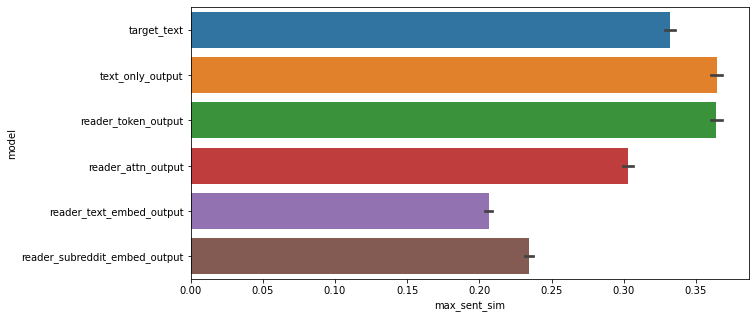

In [24]:
## flatten data lol
target_text_vars = ['target_text', 'text_only_output', 'reader_token_output', 'reader_attn_output', 'reader_text_embed_output', 'reader_subreddit_embed_output']
sent_sim_vars = [f'{x}_max_sim_sent_val' for x in target_text_vars]
flat_sent_sim_data = pd.melt(sample_combined_data.loc[:, sent_sim_vars], value_vars=sent_sim_vars, var_name='model', value_name='max_sent_sim')
flat_sent_sim_data = flat_sent_sim_data[flat_sent_sim_data.loc[:, 'max_sent_sim']<=max_sim_cutoff_val]
# clean model name
flat_sent_sim_data = flat_sent_sim_data.assign(**{
    'model' : flat_sent_sim_data.loc[:, 'model'].apply(lambda x: x.replace('_max_sim_sent_val', ''))
})
## plot everything
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(10,5))
sns.barplot(data=flat_sent_sim_data, y='model', x='max_sent_sim')
plt.show()

OK! The simplest models tend to produce answers with high similarity. That's not necessarily a bad thing for the other models!

Let's verify this on the data with reader tokens and the data with reader embeds.

In [47]:
def plot_sent_sim(data, target_text_vars):
    sent_sim_vars = [f'{x}_max_sim_sent_val' for x in target_text_vars]
    flat_sent_sim_data = pd.melt(data.loc[:, sent_sim_vars], value_vars=sent_sim_vars, var_name='model', value_name='max_sent_sim')
    flat_sent_sim_data = flat_sent_sim_data[flat_sent_sim_data.loc[:, 'max_sent_sim']<=max_sim_cutoff_val]
    # clean model name
    flat_sent_sim_data = flat_sent_sim_data.assign(**{
        'model' : flat_sent_sim_data.loc[:, 'model'].apply(lambda x: x.replace('_max_sim_sent_val', ''))
    })
    ## plot everything
    plt.figure(figsize=(10,5))
    sns.barplot(data=flat_sent_sim_data, y='model', x='max_sent_sim')
    plt.show()

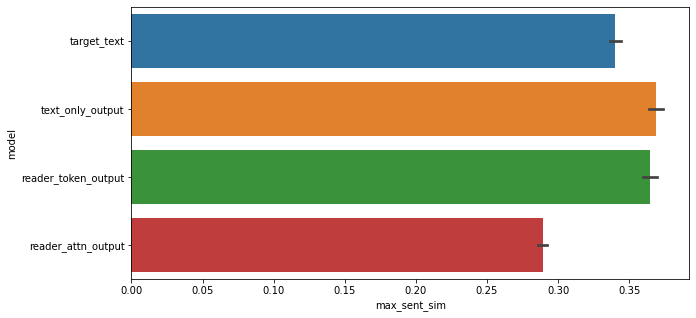

In [48]:
## reader tokens
sample_combined_data_with_reader_tokens = sample_combined_data[sample_combined_data.loc[:, 'reader_token']!='UNK']
target_text_vars = ['target_text', 'text_only_output', 'reader_token_output', 'reader_attn_output']
plot_sent_sim(sample_combined_data_with_reader_tokens, target_text_vars)

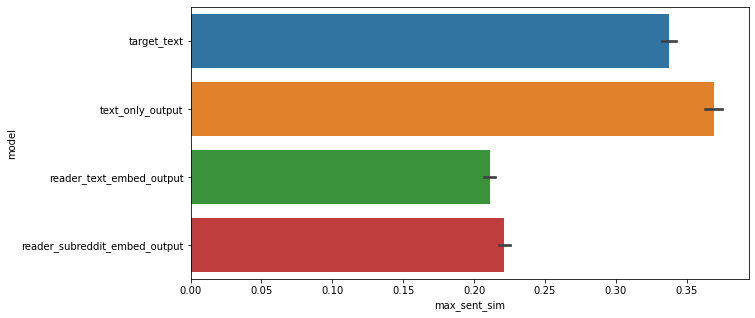

In [49]:
## reader embeds
sample_combined_data_with_embeds = sample_combined_data[sample_combined_data.loc[:, 'author_has_subreddit_embed'] & sample_combined_data.loc[:, 'author_has_text_embed']]
target_text_vars = ['target_text', 'text_only_output', 'reader_text_embed_output', 'reader_subreddit_embed_output']
plot_sent_sim(sample_combined_data_with_embeds, target_text_vars)

The model differences on the sub-set data are basically the same as the full data.

### Post overlap: topic

In [249]:
# optional: extract best vocab from all posts
from sklearn.feature_extraction.text import CountVectorizer
from nltk.tokenize import WordPunctTokenizer
from stop_words import get_stop_words
en_stops = get_stop_words('en')
word_tokenizer = WordPunctTokenizer()
cv = CountVectorizer(min_df=0.0001, max_df=0.25, stop_words=en_stops, tokenizer=word_tokenizer.tokenize)
dtm = cv.fit_transform(combined_data.loc[:, 'source_text'].values)
# show top words
print(f'top words in docs')
print(pd.Series(np.array(dtm.sum(axis=0))[0], index=sorted(cv.vocabulary_, key=cv.vocabulary_.get)).sort_values(inplace=False, ascending=False).head(10))
dtm_vocab = set(cv.vocabulary_.keys())
# get corpus for LDA
from gensim.corpora import Dictionary
from nltk.tokenize import WordPunctTokenizer
word_tokenizer = WordPunctTokenizer()
source_text_tokens = combined_data.loc[:, 'source_text'].apply(lambda x: list(filter(lambda y: y in dtm_vocab, word_tokenizer.tokenize(x))))
lda_dict = Dictionary(source_text_tokens)
lda_corpus = source_text_tokens.apply(lda_dict.doc2bow).values
## find best # topics based on coherence
from gensim.models import LdaModel
from gensim.models.coherencemodel import CoherenceModel
k_topics = [5, 10, 15, 20]
topic_metrics = []
for k_topic in k_topics:
    print(f'testing topics = {k_topic}')
    lda_model = LdaModel(lda_corpus, num_topics=k_topic, alpha='symmetric', iterations=100)
    print(f'computing coherence')
    coherence_model = CoherenceModel(model=lda_model, corpus=lda_corpus, texts=source_text_tokens, dictionary=lda_dict, coherence='c_v')
    coherence_k = coherence_model.get_coherence()
    topic_metrics.append(coherence_k)
topic_metrics = pd.Series(topic_metrics, index=k_topics)
print(topic_metrics)

top words in docs
$        43571
"        42040
:        26893
didn     23718
money    22976
;        22778
feel     22336
since    21575
think    20997
home     20821
dtype: int64
testing topics = 5
computing coherence
testing topics = 10
computing coherence
testing topics = 15
computing coherence
testing topics = 20
computing coherence
5     0.388676
10    0.420840
15    0.404000
20    0.387441
dtype: float64


In [250]:
optimal_k_topic = 10
lda_model = LdaModel(lda_corpus, num_topics=optimal_k_topic, alpha='symmetric', id2word=lda_dict, iterations=100)
# show top words per topic
lda_model.print_topics(num_words=10)

[(0,
  '0.038*"$" + 0.013*"money" + 0.012*"pay" + 0.010*"job" + 0.010*"month" + 0.008*"credit" + 0.008*"%" + 0.008*":" + 0.007*"debt" + 0.007*"000"'),
 (1,
  '0.021*""" + 0.009*"friends" + 0.008*"feel" + 0.008*"friend" + 0.008*"people" + 0.006*"didn" + 0.006*"think" + 0.006*"say" + 0.005*"something" + 0.005*"guy"'),
 (2,
  '0.013*"school" + 0.012*"parents" + 0.010*"son" + 0.010*"mother" + 0.009*"kids" + 0.008*"daughter" + 0.008*"family" + 0.007*""" + 0.006*"mom" + 0.006*"us"'),
 (3,
  '0.052*";" + 0.047*"amp" + 0.036*";#" + 0.026*"&" + 0.025*":" + 0.016*".&" + 0.012*"://" + 0.012*"com" + 0.011*"https" + 0.009*"**"'),
 (4,
  '0.016*"dog" + 0.009*""" + 0.009*"people" + 0.008*"water" + 0.008*"food" + 0.008*"day" + 0.006*"boss" + 0.006*")." + 0.005*"asked" + 0.005*"hours"'),
 (5,
  '0.014*"account" + 0.010*"dad" + 0.009*"sister" + 0.008*"mom" + 0.008*"help" + 0.007*"phone" + 0.007*"card" + 0.006*"tried" + 0.006*"check" + 0.006*"dont"'),
 (6,
  '0.010*"feel" + 0.009*"husband" + 0.008*"thing

These seem mainly split between `money` and `family` words, which makes sense.

In [264]:
# get topics for all documents
post_topics = lda_model.get_document_topics(lda_corpus, minimum_probability=0.)
post_topics = pd.DataFrame(list(map(lambda x: pd.Series(dict(x)), post_topics)))

(59273, 10)


,0,1,2,3,4,5,6,7,8,9
0,0.002861,0.002861,0.096314,0.571527,0.002861,0.071558,0.002861,0.243434,0.002861,0.002861
1,0.043867,0.000585,0.000585,0.000585,0.951453,0.000585,0.000585,0.000585,0.000585,0.000585
2,0.000505,0.000505,0.000505,0.000505,0.000505,0.923927,0.000505,0.000505,0.000505,0.072030
3,0.000538,0.000538,0.000538,0.000538,0.000538,0.000538,0.000538,0.000538,0.000538,0.995158
4,0.000820,0.000820,0.000820,0.000820,0.000820,0.000820,0.992622,0.000820,0.000820,0.000820


In [280]:
## compute cosine similarity between post and question topics, for each post-question pair
from sklearn.metrics.pairwise import cosine_similarity
target_text_vars = ['target_text', 'text_only_output', 'reader_token_output', 'reader_attn_output', 'reader_text_embed_output', 'reader_subreddit_embed_output']
combined_data_topic_sims = []
for target_text_var in target_text_vars:
    print(f'testing topics for var={target_text_var}')
    question_lda_tokens = combined_data.loc[:, target_text_var].apply(lambda x: list(filter(lambda y: y in dtm_vocab, word_tokenizer.tokenize(x))))
    question_lda_corpus = question_lda_tokens.apply(lda_dict.doc2bow).values
    question_topics = lda_model.get_document_topics(question_lda_corpus, minimum_probability=0.)
    question_topics = pd.DataFrame(list(map(lambda x: pd.Series(dict(x)), question_topics)))
    post_question_sims = []
    for i in tqdm(range(post_topics.shape[0])):
        post_question_sim_i = cosine_similarity(post_topics.iloc[i, :].values.reshape(1,-1), question_topics.iloc[i, :].values.reshape(1,-1))[0][0]
        post_question_sims.append(post_question_sim_i)
    post_question_sims = pd.DataFrame(post_question_sims, columns=['post_question_topic_sim']).assign(**{'model' : target_text_var})
    combined_data_topic_sims.append(post_question_sims)
combined_data_topic_sims = pd.concat(combined_data_topic_sims, axis=0)

testing topics for var=target_text


100%|██████████| 59273/59273 [00:23<00:00, 2498.68it/s]


testing topics for var=text_only_output


100%|██████████| 59273/59273 [00:23<00:00, 2488.53it/s]


testing topics for var=reader_token_output


100%|██████████| 59273/59273 [00:25<00:00, 2338.64it/s]


testing topics for var=reader_attn_output


100%|██████████| 59273/59273 [00:27<00:00, 2178.75it/s]


testing topics for var=reader_text_embed_output


100%|██████████| 59273/59273 [00:26<00:00, 2242.06it/s]


testing topics for var=reader_subreddit_embed_output


100%|██████████| 59273/59273 [00:26<00:00, 2276.07it/s]


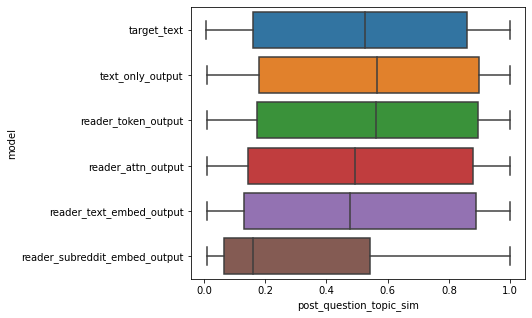

In [288]:
## plot post-topic sims
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(6,5))
sns.boxplot(data=combined_data_topic_sims, x='post_question_topic_sim', y='model')
plt.show()

OK! 

- The `text_only` model and `reader_token` model seem to "overfit" and produce text that is more topically similar than the actual questions.
- The `reader_attn` model and `text_embed` model are a bit closer to the expected value of topical similarity.